In [1]:
import torch
# torch.cu()

a=torch.cuda.get_device_properties(0)

torch.clear_autocast_cache()

a.total_memory

torch.cuda.memory_allocated()

torch.cuda.memory_reserved()

torch.cuda.memory_cached()

In [103]:
%%writefile experiment_8_label_versions.py
import torch
import numpy as np
import pandas as pd
import transformers
import torch
import evaluate
import datasets
import sys
    
model_arch = "small" 
batch_size=10
label_version = sys.argv[1]
output_dir = f"/home/moshebr/dharelg/moshe/experiment_8_batchsize{batch_size}_modelarc{model_arch}_labels{label_version}"
max_steps=15000 # how many data sample to read (epochs=steps / samples)
accumulation_steps=1 
print("model_arch:",model_arch)
print("batch_size:",batch_size)
print("max_steps(data sample iterations):",max_steps)
print("accumulation_steps:",accumulation_steps)
print("label_version:",label_version)
print("output_dir:",output_dir)

torch.manual_seed(42)  # Or any other number you like
processor = transformers.WhisperProcessor.from_pretrained(f"openai/whisper-{model_arch}", language="english", task="transcribe")
feature_extractor = processor.feature_extractor
tokenizer = processor.tokenizer

model = transformers.WhisperForConditionalGeneration.from_pretrained(f"openai/whisper-{model_arch}")
model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="english", task="transcribe")
model.config.suppress_tokens = []

common_voice = datasets.DatasetDict.load_from_disk("/home/moshebr/dharelg/moshe/ds_eran_original_v1")
if label_version != "reg":
    common_voice = common_voice.remove_columns(["labels"]).rename_column(f"labels_{label_version}","labels")

def data_collator(features: "List[Dict[str, Union[List[int], torch.Tensor]]]") -> "Dict[str, torch.Tensor]":
    # split inputs and labels since they have to be of different lengths and need different padding methods
    # first treat the audio inputs by simply returning torch tensors
    input_features = [{"input_features": feature["input_features"]} for feature in features]
    batch = processor.feature_extractor.pad(input_features, return_tensors="pt")

    # get the tokenized label sequences
    label_features = [{"input_ids": feature["labels"]} for feature in features]
    # pad the labels to max length
    labels_batch = processor.tokenizer.pad(label_features, return_tensors="pt")

    # replace padding with -100 to ignore loss correctly
    labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

    # if bos token is appended in previous tokenization step,
    # cut bos token here as it's append later anyways
    if (labels[:, 0] == processor.tokenizer.bos_token_id).all().cpu().item():
        labels = labels[:, 1:]

    batch["labels"] = labels

    return batch

metric = evaluate.load("wer")
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

# defining the optimizer and scheduler
max_batches=max_steps//batch_size # how many batches to train
warmup_batches=500//batch_size
def lr_lambda(step):
    if step<warmup_batches:
        factor=float(step) / float(max(1, warmup_batches))
    else:
        remaining_steps = max_batches - step
        max_remaining_steps = max_batches - warmup_batches
        factor=max(0.0, float(remaining_steps) / float(max(1, max_remaining_steps)))
    return factor
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-5)
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer=optimizer,
    lr_lambda=lr_lambda,
)

# epochs = batchsize*step/dataset_size

training_args = transformers.Seq2SeqTrainingArguments(
    output_dir =output_dir,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=accumulation_steps,
    # learning_rate=1e-5,
    # warmup_steps=500//batch_size,
    max_steps=max_batches,
    gradient_checkpointing=True, # trick to conserve GPU-memory (longer training time in order to fit in memory). only possible to disable with a tiny model
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=batch_size,
    # all the arguments from here on deal with loggin and evaluation (should have no affect on the training procedure!!)
    predict_with_generate=True,
    generation_max_length=448,
    save_steps=1000//batch_size, 
    eval_steps=1000//batch_size,
    logging_steps=30//batch_size,
    report_to=["none"],
    load_best_model_at_end=False,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
)

trainer = transformers.Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    optimizers=(optimizer,scheduler),
)
# processor.save_pretrained(training_args.output_dir)
trainer.train()

Overwriting experiment_8_label_versions.py


In [104]:
%%writefile experiment_8_label_versions.sh
sbatch <<EOT
#!/bin/bash
#SBATCH --job-name=booya # Job name
#SBATCH --mem=30gb # Job memory request
#SBATCH --partition=normal.q # partition request
#SBATCH --gres=gpu:a10:1 # GPU devices request
#SBATCH --output=/home/moshebr/notebooks/lets_do_whisper/experiment_8_label_versions${1}.log # Standard output and error log
#SBATCH --time=1:00:00 # Time limitation (here 15 minutes)
#SBATCH --mail-user=barboym@yahoo.com # Email address for notification sending
#SBATCH --mail-type=END,FAIL # When to send email notification
/home/moshebr/.conda/envs/whisper/bin/python /home/moshebr/notebooks/lets_do_whisper/experiment_8_label_versions.py ${1}
EOT

Overwriting experiment_8_label_versions.sh


In [105]:
!bash experiment_8_label_versions.sh reg

Submitted batch job 34271


In [106]:
!bash experiment_8_label_versions.sh v1

Submitted batch job 34272


In [110]:
# !bash experiment_8_label_versions.sh reg
# !bash experiment_8_label_versions.sh v1
# !bash experiment_8_label_versions.sh v2
# !bash experiment_8_label_versions.sh v3
# !bash experiment_8_label_versions.sh v4

In [7]:
!ls /home/moshebr/dharelg/moshe/experiment_8_batchsize10_modelarcsmall_labelsv5/checkpoint-100/ -lh 

total 3.5G
-rw-rw----+ 1 moshebr users 1.4K Aug 14 15:49 config.json
-rw-rw----+ 1 moshebr users 3.8K Aug 14 15:49 generation_config.json
-rw-rw----+ 1 moshebr users 1.9G Aug 14 15:50 optimizer.pt
-rw-rw----+ 1 moshebr users 923M Aug 14 15:50 pytorch_model.bin
-rw-rw----+ 1 moshebr users  15K Aug 14 15:50 rng_state.pth
-rw-rw----+ 1 moshebr users  557 Aug 14 15:50 scaler.pt
-rw-rw----+ 1 moshebr users  563 Aug 14 15:50 scheduler.pt
-rw-rw----+ 1 moshebr users 4.4K Aug 14 15:50 trainer_state.json
-rw-rw----+ 1 moshebr users 3.8K Aug 14 15:50 training_args.bin


In [15]:
!squeue

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
             34301    long.q     bash   sarahk  R    6:58:07      1 n115
             34316    long.q     bash  royabel  R    2:33:24      1 n116
             34306    long.q     bash   akhiad  R    4:51:16      1 n131
             34307  normal.q     bash   eranbe  R    4:46:18      1 n115
             34318  normal.q     bash  moshebr  R    1:13:38      1 n116
             34304  normal.q     bash zacharyl  R    5:17:37      1 n114


In [19]:
from segmenter.using_whisper.evaluation_on_dataset import get_whisper_tagging_on_dataset
from segmenter.using_whisper.model_inference import get_model
import datasets
import torch

import pandas as pd
from sklearn import metrics

def get_evaluation_on_testset(model_path,model_arc):
    device = torch.device("cuda")
    model = get_model(
        device=device,
        model_path=model_path,
        model_arc=model_arc,
    )
    ds = datasets.DatasetDict.load_from_disk("/home/moshebr/dharelg/moshe/ds_eran_original/")["test"]
    df_eval_for_ds_ = get_whisper_tagging_on_dataset(ds,model)

    rr=df_eval_for_ds_
    rr_wo_dups = rr[rr.dataset_id.duplicated()]
    return pd.Series({
        "segmentation_kappa":metrics.cohen_kappa_score(rr.segmentation_truth,rr.segmentation_pred),
        "segmentation_kappa_wo_start_of_turns":metrics.cohen_kappa_score(rr_wo_dups.segmentation_truth,rr_wo_dups.segmentation_pred),
        "focus_kappa":metrics.cohen_kappa_score(rr.emphasis_truth,rr.emphasis_pred),
        "prototype_kappa":metrics.cohen_kappa_score(rr.prototype_truth,rr.prototype_pred),
        "model_path":model_path,
        "model_arc":model_arc,
    })

eval_s = get_evaluation_on_testset(
    "/home/moshebr/dharelg/moshe/experiment_4_batchsize10_modelarcsmall/checkpoint-300/pytorch_model.bin",
    "small",
)
eval_s

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [01:14<00:00,  1.28s/it]


segmentation_kappa                                                               0.924949
segmentation_kappa_wo_start_of_turns                                             0.905512
focus_kappa                                                                      0.405331
prototype_kappa                                                                  0.305048
model_path                              /home/moshebr/dharelg/moshe/experiment_4_batch...
model_arc                                                                           small
dtype: object

In [20]:
eval_s_100 = get_evaluation_on_testset(
    "/home/moshebr/dharelg/moshe/experiment_4_batchsize10_modelarcsmall/checkpoint-100/pytorch_model.bin",
    "small",
)
eval_s_100

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [01:14<00:00,  1.28s/it]


segmentation_kappa                                                               0.906046
segmentation_kappa_wo_start_of_turns                                             0.882508
focus_kappa                                                                       0.18395
prototype_kappa                                                                  0.003341
model_path                              /home/moshebr/dharelg/moshe/experiment_4_batch...
model_arc                                                                           small
dtype: object

In [ ]:
# added optimizers=(torch.optim.AdamW(model.parameters()),None),. I think it proves that we don't know for sure what are the optimizer parameters.. 

model_arch: small
batch_size: 10
max_steps: 3000
accumulation_steps: 1
output_dir: /home/moshebr/dharelg/moshe/experiment_3_batchsize10_modelarcsmall

`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...

[300/300 12:16, Epoch 2/3]
Step 	Training Loss 	Validation Loss 	Wer
100 	1.281200 	1.295279 	266.139241
200 	1.113900 	1.104030 	146.413502
300 	0.828100 	1.060198 	138.554852

TrainOutput(global_step=300, training_loss=1.1355353116989135, metrics={'train_runtime': 739.7354, 'train_samples_per_second': 4.056, 'train_steps_per_second': 0.406, 'total_flos': 8.6229317615616e+17, 'train_loss': 1.1355353116989135, 'epoch': 2.7})



In [ ]:
# created the optimizer and scheduler manually

model_arch: small
batch_size: 10
max_steps(data sample iterations): 3000
accumulation_steps: 1
output_dir: /home/moshebr/dharelg/moshe/experiment_4_batchsize10_modelarcsmall

[300/300 12:11, Epoch 2/3]
Step 	Training Loss 	Validation Loss 	Wer
100 	0.316700 	0.188250 	47.415612
200 	0.183400 	0.123413 	34.915612
300 	0.087000 	0.109278 	32.542194

TrainOutput(global_step=300, training_loss=0.41007178008556366, metrics={'train_runtime': 733.4905, 'train_samples_per_second': 4.09, 'train_steps_per_second': 0.409, 'total_flos': 8.6229317615616e+17, 'train_loss': 0.41007178008556366, 'epoch': 2.7})

In [ ]:
# commented out tokenizer=processor.feature_extractor, (which proves that this method does padding which we don't need)

model_arch: small
batch_size: 10
max_steps: 3000
accumulation_steps: 1
output_dir: /home/moshebr/dharelg/moshe/experiment_3_batchsize10_modelarcsmall

[300/300 12:22, Epoch 2/3]
Step 	Training Loss 	Validation Loss 	Wer
100 	0.317300 	0.188508 	47.995781
200 	0.185300 	0.122076 	35.495781
300 	0.086800 	0.109687 	32.647679

TrainOutput(global_step=300, training_loss=0.41093962331612904, metrics={'train_runtime': 745.9517, 'train_samples_per_second': 4.022, 'train_steps_per_second': 0.402, 'total_flos': 8.6229317615616e+17, 'train_loss': 0.41093962331612904, 'epoch': 2.7})

In [ ]:
model_arch: medium
batch_size: 10
max_steps: 6000
accumulation_steps: 1
output_dir: /home/moshebr/dharelg/moshe/experiment_2_batchsize10_modelarcmedium

Step 	Training Loss 	Validation Loss 	Wer
100 	0.223000 	0.128280 	40.295359
200 	0.141300 	0.116458 	46.308017
300 	0.071000 	0.101251 	25.632911
400 	0.030600 	0.112292 	25.843882
500 	0.014600 	0.143902 	25.843882
600 	0.008400 	0.149473 	24.683544

In [9]:
transformers.Seq2SeqTrainingArguments?

Init signature:
transformers.Seq2SeqTrainingArguments(
    output_dir: str,
    overwrite_output_dir: bool = False,
    do_train: bool = False,
    do_eval: bool = False,
    do_predict: bool = False,
    evaluation_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no',
    prediction_loss_only: bool = False,
    per_device_train_batch_size: int = 8,
    per_device_eval_batch_size: int = 8,
    per_gpu_train_batch_size: Optional[int] = None,
    per_gpu_eval_batch_size: Optional[int] = None,
    gradient_accumulation_steps: int = 1,
    eval_accumulation_steps: Optional[int] = None,
    eval_delay: Optional[float] = 0,
    learning_rate: float = 5e-05,
    weight_decay: float = 0.0,
    adam_beta1: float = 0.9,
    adam_beta2: float = 0.999,
    adam_epsilon: float = 1e-08,
    max_grad_norm: float = 1.0,
    num_train_epochs: float = 3.0,
    max_steps: int = -1,
    lr_scheduler_type: Union[transformers.trainer_utils.SchedulerType, str] = 'linear',
    warmup_ratio

In [110]:
%%writefile recreation_script_again_w_arch.sh
sbatch <<EOT
#!/bin/bash
#SBATCH --job-name=booya # Job name
#SBATCH --mem=60gb # Job memory request
#SBATCH --partition=long.q # partition request
#SBATCH --gres=gpu:a10:1 # GPU devices request
#SBATCH --output=/home/moshebr/notebooks/lets_do_whisper/recreation_script_again_w_arch${1}.log # Standard output and error log
#SBATCH --time=12:00:00 # Time limitation (here 15 minutes)
#SBATCH --mail-user=barboym@yahoo.com # Email address for notification sending
#SBATCH --mail-type=END,FAIL # When to send email notification
/home/moshebr/.conda/envs/whisper/bin/python /home/moshebr/notebooks/lets_do_whisper/recreation_script_again_w_arch.py ${1}
EOT

Overwriting recreation_script_again_w_arch.sh


In [172]:
%%writefile recreation_script_again_w_arch_datacached.sh
sbatch <<EOT
#!/bin/bash
#SBATCH --job-name=booya # Job name
#SBATCH --mem=60gb # Job memory request
#SBATCH --partition=normal.q # partition request
#SBATCH --gres=gpu:a10:1 # GPU devices request
#SBATCH --output=/home/moshebr/notebooks/lets_do_whisper/recreation_script_again_w_arch${1}_datacached.log # Standard output and error log
#SBATCH --time=1:00:00 # Time limitation (here 15 minutes)
#SBATCH --mail-user=barboym@yahoo.com # Email address for notification sending
#SBATCH --mail-type=END,FAIL # When to send email notification
/home/moshebr/.conda/envs/whisper/bin/python /home/moshebr/notebooks/lets_do_whisper/recreation_script_again_w_arch_datacached.py ${1}
EOT

Overwriting recreation_script_again_w_arch_datacached.sh


In [111]:
!bash /home/moshebr/notebooks/lets_do_whisper/recreation_script_again_w_arch.sh tiny

Submitted batch job 33748


In [173]:
!bash /home/moshebr/notebooks/lets_do_whisper/recreation_script_again_w_arch_datacached.sh tiny

Submitted batch job 33755


In [121]:
!bash /home/moshebr/notebooks/lets_do_whisper/recreation_script_again_w_arch.sh small

Submitted batch job 33749


In [122]:
!bash /home/moshebr/notebooks/lets_do_whisper/recreation_script_again_w_arch.sh medium

Submitted batch job 33750


In [1]:
!squeue

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON) 
             33813  normal.q     bash    shify  R    2:11:10      1 n114 
             33812  normal.q     bash  moshebr  R    2:45:00      1 n115 
             33814    long.q     bash  sverkip  R    1:11:36      1 n131 
             33815    long.q     bash     liav  R      38:30      1 n114 
             33810    long.q     bash   rodfon  R    4:53:00      1 n114 
             33811    long.q     bash  royabel  R    2:49:37      1 n115 


In [113]:
ls /home/moshebr/notebooks/lets_do_whisper/recreation_script_again_w_arch*

/home/moshebr/notebooks/lets_do_whisper/recreation_script_again_w_arch${1}.log
/home/moshebr/notebooks/lets_do_whisper/recreation_script_again_w_arch.py
/home/moshebr/notebooks/lets_do_whisper/recreation_script_again_w_arch.sh
/home/moshebr/notebooks/lets_do_whisper/recreation_script_again_w_archsmall.log
/home/moshebr/notebooks/lets_do_whisper/recreation_script_again_w_archtiny.log


In [199]:
!cat /home/moshebr/notebooks/lets_do_whisper/recreation_script_again_w_arch{tiny}_datacached.log

Opening a new Slurm session:
SLURM_JOB_ID = 33755
SLURM_NODELIST = n120
------------------------------------------
Personal temporary local directory allocated: $TMPDIR=/local_data/33755_moshebr/
Your free local storage on your $TMPDIR is currently:  695G
You can use variable name $TMPDIR in your session
.
/home/moshebr/.conda/envs/whisper/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
model_arch: tiny
100%|██████████| 1000/1000 [30:18<00:00,  1.80s/it]{'loss': 4.0578, 'learning_rate': 4.800000000000001e-07, 'epoch': 0.36}
{'loss': 3.6314, 'learning_rate': 9.800000000000001e-07, 'epoch': 0.72}
{'loss': 3.069, 'learning_rate': 1.46e-06, 'epoch': 1.09}
{'loss': 2.3793, 'learning_rate': 1.9600000000000003e-06, 'epoch': 1.45}
{'loss': 1.7233, 

In [197]:
!cat /home/moshebr/notebooks/lets_do_whisper/recreation_script_again_w_arch{tiny,small,medium}.log

Opening a new Slurm session:
SLURM_JOB_ID = 33748
SLURM_NODELIST = n131
------------------------------------------
Personal temporary local directory allocated: $TMPDIR=/local_data/33748_moshebr/
Your free local storage on your $TMPDIR is currently:  695G
You can use variable name $TMPDIR in your session
.
model_arch: tiny
/home/moshebr/.conda/envs/whisper/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 1000/1000 [27:21<00:00,  1.63s/it]{'loss': 4.0579, 'learning_rate': 4.800000000000001e-07, 'epoch': 0.36}
{'loss': 3.6314, 'learning_rate': 9.800000000000001e-07, 'epoch': 0.72}
{'loss': 3.0689, 'learning_rate': 1.46e-06, 'epoch': 1.09}
{'loss': 2.3792, 'learning_rate': 1.9600000000000003e-06, 'epoch': 1.45}
{'loss': 1.7231,

In [144]:
!cat /home/moshebr/notebooks/lets_do_whisper/recreation_script_again{_w_tiny,_w_small,_w_medium_wo_tokenizer}.log

Opening a new Slurm session:
SLURM_JOB_ID = 33744
SLURM_NODELIST = n131
------------------------------------------
Personal temporary local directory allocated: $TMPDIR=/local_data/33744_moshebr/
Your free local storage on your $TMPDIR is currently:  695G
You can use variable name $TMPDIR in your session
.
/home/moshebr/.conda/envs/whisper/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  2%|▏         | 15/1000 [01:44<1:53:06,  6.89s/it]slurmstepd: error: *** JOB 33744 ON n131 CANCELLED AT 2023-07-10T11:13:40 ***
Opening a new Slurm session:
SLURM_JOB_ID = 33743
SLURM_NODELIST = n131
------------------------------------------
Personal temporary local directory allocated: $TMPDIR=/local_data/33743_moshebr/
Your free local storage on your $TM

In [2]:
!cat /home/moshebr/notebooks/lets_do_whisper/recreation_script_again_w_medium{,_wo_metrics}.log

Opening a new Slurm session:
SLURM_JOB_ID = 33728
SLURM_NODELIST = n131
------------------------------------------
Personal temporary local directory allocated: $TMPDIR=/local_data/33728_moshebr/
Your free local storage on your $TMPDIR is currently:  695G
You can use variable name $TMPDIR in your session
.
/home/moshebr/.conda/envs/whisper/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 1000/1000 [1:57:04<00:00,  7.01s/it]{'loss': 3.1, 'learning_rate': 4.2000000000000006e-07, 'epoch': 0.36}
{'loss': 2.0442, 'learning_rate': 9.200000000000001e-07, 'epoch': 0.72}
{'loss': 1.2439, 'learning_rate': 1.4000000000000001e-06, 'epoch': 1.09}
{'loss': 0.7799, 'learning_rate': 1.9000000000000002e-06, 'epoch': 1.45}
{'loss': 0.55, 'lea

# caching dataset 

In [53]:
# %%writefile example_caching_data_script_finalfinalfinal.py
from transformers import WhisperProcessor
from transformers import WhisperForConditionalGeneration
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
import librosa
import torch
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from transformers import pipeline
import gradio as gr
from evaluate.evaluator import text2text_generation
from transformers import pipeline
from evaluate.evaluator import text2text_generation
from transformers import pipeline
import gradio as gr
import librosa
import pandas as pd
import numpy as np
import pickle
from datasets import Dataset, DatasetDict
import transformers
import torch
import evaluate
import sys 

from dataclasses import dataclass
from typing import Any, Dict, List, Union

# Load the list from the file
# with open("/home/yadinb/dharelg/yadinb/alona_tag_data_POC.pkl", 'rb') as f:
#     df = pd.DataFrame(pickle.load(f))
with open(
    "/home/yadinb/dharelg/datasets/whisper_dataset/notebooks_for_processing_data4prototype_and_focus_tal_alona/pickle_step2/all_data_list_poc_segprotfoc_include21.pkl",
    'rb'
) as f:
    df = pd.DataFrame(pickle.load(f))
for index, row in df.iterrows():
    row['audio']['array'] = np.array(row['audio']['array'], dtype=np.float32)

    

model_arch = "tiny"
print("model_arch:",model_arch)
output_dir = f"/home/moshebr/dharelg/moshe/recreation_script_again_w_{model_arch}"

seed = 42  # Or any other number you like

train_df = df.iloc[:int(0.95*len(df))]
train_df = train_df.sample(frac=1, random_state=seed).reset_index(drop=True)  # shuffle and reset index
train_dataset = Dataset.from_pandas(train_df)



# Create the Dataset objects
#train_dataset = Dataset.from_pandas(df.iloc[:int(0.95*len(df))])




test_dataset = Dataset.from_pandas(df.iloc[int(0.95*len(df)):])

# Create the DatasetDict object
dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

# TEST_DF = df.iloc[int(0.95*len(df)):]
# feature_extractor = transformers.WhisperFeatureExtractor.from_pretrained(f"openai/whisper-{model_arch}")

# tokenizer = transformers.WhisperTokenizer.from_pretrained(f"openai/whisper-{model_arch}", language="english", task="transcribe")

processor = transformers.WhisperProcessor.from_pretrained(f"openai/whisper-{model_arch}", language="english", task="transcribe")
tokenizer = processor.tokenizer 
feature_extractor = processor.feature_extractor 

#need to trancate sequence ,model works only with 1024 token.
#@@@@@@@@@@
#@@@@@@@@@@
#$$$$$$$$$$$$$$$$$
#MAX_LENGTH = 1024
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]
    # truncate target text to a maximum length
    #sentence = batch["sentence"][:MAX_LENGTH]
    sentence = batch["sentence"]

    # compute input length of audio sample in seconds
    batch["input_length"] = len(audio["array"]) / audio["sampling_rate"]
    batch["audio_path"] = audio["path"]
    # encode target text to label ids
    labels_ids = tokenizer(sentence).input_ids
    # truncate labels to a maximum length
    #labels_ids = labels_ids[:MAX_LENGTH]
    batch["labels"] = labels_ids
    return batch
dataset = dataset_dict.map(prepare_dataset, remove_columns=dataset_dict.column_names["train"], num_proc=8)
max_input_length = 30
min_input_length = 0


def is_audio_in_length_range(length):
    return length > min_input_length and length <= max_input_length
vectorized_datasets = dataset.filter(
    is_audio_in_length_range, num_proc=1, input_columns=["input_length"]
)

model = transformers.WhisperForConditionalGeneration.from_pretrained(f"openai/whisper-{model_arch}")
model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="english", task="transcribe")
model.config.suppress_tokens = []
max_label_length = model.config.max_length
def is_labels_in_length_range(labels):
    return len(labels) < max_label_length
common_voice = vectorized_datasets.filter(
    is_labels_in_length_range, num_proc=1, input_columns=["labels"]
)

model_arch: tiny


Map (num_proc=8):   0%|          | 0/1168 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1579 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1586 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1704 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3800 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2174 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence leng

Map (num_proc=8):   0%|          | 0/62 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1168 [00:00<?, ? examples/s]

Filter:   0%|          | 0/62 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1134 [00:00<?, ? examples/s]

Filter:   0%|          | 0/61 [00:00<?, ? examples/s]

# adding labels

In [9]:
import transformers
processor = transformers.WhisperProcessor.from_pretrained(f"openai/whisper-small", language="english", task="transcribe")
tokenizer = processor.tokenizer

for a in ["T","F"]:
    for b in ['1','2','3']:
        for c in ["T","F"]:
            assert len(tokenizer.encode(f" {a}{b}{c}",add_special_tokens=False))==3

In [87]:
import transformers
processor = transformers.WhisperProcessor.from_pretrained(f"openai/whisper-small", language="english", task="transcribe")
tokenizer = processor.tokenizer

for a in ["A","B","C","D"]:
    for b in ['1','2']:
        assert len(tokenizer.encode(f" {a}{b}",add_special_tokens=False))==2, f"{a}{b}"

In [91]:
tokenizer.encode(f" A1",add_special_tokens=False)

[316, 16]

In [14]:
"FALSE1FALSE".replace("FALSE","F").replace("TRUE","T")

'F1F'

In [1]:
import pandas as pd
import datasets
import transformers
common_voice=datasets.DatasetDict.load_from_disk("/home/moshebr/dharelg/moshe/ds_eran_original")
processor = transformers.WhisperProcessor.from_pretrained(f"openai/whisper-small", language="english", task="transcribe")
tokenizer = processor.tokenizer

tag_dict = {
    "FALSE1FALSE":"A",
    "FALSE1TRUE":"B",
    "FALSE2FALSE":"C",
    "FALSE2TRUE":"D",
    "FALSE3FALSE":"E",
    "FALSE3TRUE":"F",
    "TRUE1FALSE":"G",
    "TRUE1TRUE":"H",
    "TRUE2FALSE":"I",
    "TRUE2TRUE":"J",
    "TRUE3FALSE":"K",
    "TRUE3TRUE":"L",
} # v1 evaluation taylored for 

tag_dict_2 = {k:k.replace("FALSE","F").replace("TRUE","T") for k in tag_dict.keys()}

tag_dict_3 = {k:v[::-1] for k,v in tag_dict_2.items()}
tag_dict_4 = {k:k[::-1].replace("FALSE"[::-1],"FALSE").replace("TRUE"[::-1],"TRUE") for k,v in tag_dict_2.items()} # the regular evaluation should work

tag_dict_5 = {
    "FALSE1FALSE":"A1",
    "FALSE1TRUE":"A2",
    "FALSE2FALSE":"A1",
    "FALSE2TRUE":"A2",
    "FALSE3FALSE":"A1",
    "FALSE3TRUE":"A2",
    "TRUE1FALSE":"B1",
    "TRUE1TRUE":"B2",
    "TRUE2FALSE":"C1",
    "TRUE2TRUE":"C2",
    "TRUE3FALSE":"D1",
    "TRUE3TRUE":"D2",
}

# possible_tokens = [processor.tokenizer.encode(" " + v,add_special_tokens=False)[0] for v in tag_dict.values()]
def get_new_labels(instance,tag_dict,label_version):
    labels = instance["labels"]
    sentence = processor.tokenizer.decode(labels,skip_special_tokens=True)
    new_sentence = " " + " ".join(pd.Series(sentence.split()).map(lambda x:tag_dict.get(x,x)))
    new_labels = processor.tokenizer.encode(new_sentence)
    return {f"labels_{label_version}":new_labels}

common_voice = common_voice.map(get_new_labels,fn_kwargs={"tag_dict":tag_dict,"label_version":"v1"})
common_voice = common_voice.map(get_new_labels,fn_kwargs={"tag_dict":tag_dict_2,"label_version":"v2"})
common_voice = common_voice.map(get_new_labels,fn_kwargs={"tag_dict":tag_dict_3,"label_version":"v3"})
common_voice = common_voice.map(get_new_labels,fn_kwargs={"tag_dict":tag_dict_4,"label_version":"v4"})
common_voice = common_voice.map(get_new_labels,fn_kwargs={"tag_dict":tag_dict_5,"label_version":"v5"})

common_voice.save_to_disk("/home/moshebr/dharelg/moshe/ds_eran_original_v1")

Map:   0%|          | 0/1104 [00:00<?, ? examples/s]

Map:   0%|          | 0/58 [00:00<?, ? examples/s]

Map:   0%|          | 0/1104 [00:00<?, ? examples/s]

Map:   0%|          | 0/58 [00:00<?, ? examples/s]

Map:   0%|          | 0/1104 [00:00<?, ? examples/s]

Map:   0%|          | 0/58 [00:00<?, ? examples/s]

Map:   0%|          | 0/1104 [00:00<?, ? examples/s]

Map:   0%|          | 0/58 [00:00<?, ? examples/s]

Map:   0%|          | 0/1104 [00:00<?, ? examples/s]

Map:   0%|          | 0/58 [00:00<?, ? examples/s]

Saving the dataset (0/3 shards):   0%|          | 0/1104 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/58 [00:00<?, ? examples/s]

In [42]:
tag_dict_3

{'FALSE1FALSE': 'F1F',
 'FALSE1TRUE': 'T1F',
 'FALSE2FALSE': 'F2F',
 'FALSE2TRUE': 'T2F',
 'FALSE3FALSE': 'F3F',
 'FALSE3TRUE': 'T3F',
 'TRUE1FALSE': 'F1T',
 'TRUE1TRUE': 'T1T',
 'TRUE2FALSE': 'F2T',
 'TRUE2TRUE': 'T2T',
 'TRUE3FALSE': 'F3T',
 'TRUE3TRUE': 'T3T'}

In [35]:
%%writefile example_run.py
print("hello world")

%%writefile example_run.sh
sbatch <<EOT
#!/bin/bash
#SBATCH --job-name=booya # Job name
#SBATCH --mem=60gb # Job memory request
#SBATCH --partition=normal.q # partition request
#SBATCH --gres=gpu:a10:1 # GPU devices request
#SBATCH --output=/home/moshebr/notebooks/lets_do_whisper/example_run.log # Standard output and error log
#SBATCH --time=3:00:00 # Time limitation 
#SBATCH --mail-user=barboym@yahoo.com # Email address for notification sending
#SBATCH --mail-type=END,FAIL # When to send email notification
/home/moshebr/.conda/envs/whisper/bin/python /home/moshebr/notebooks/lets_do_whisper/example_run.py ${1}
EOT

!bash experiment_evaluation_batchsize_n_epoch_effect_v2.sh

# evaluation on the test set

## reg

In [24]:
%%writefile experiment_evaluation_batchsize_n_epoch_effect_reg.py
from segmenter.using_whisper.model_inference import get_model
import datasets
import torch
import whisper
import transformers
import numpy as np

import pandas as pd
from sklearn import metrics
from tqdm import tqdm

from typing import Union

tag_dict = {'FALSE1FALSE': 'FALSE1FALSE',
 'FALSE1TRUE': 'FALSE1TRUE',
 'FALSE2FALSE': 'FALSE2FALSE',
 'FALSE2TRUE': 'FALSE2TRUE',
 'FALSE3FALSE': 'FALSE3FALSE',
 'FALSE3TRUE': 'FALSE3TRUE',
 'TRUE1FALSE': 'TRUE1FALSE',
 'TRUE1TRUE': 'TRUE1TRUE',
 'TRUE2FALSE': 'TRUE2FALSE',
 'TRUE2TRUE': 'TRUE2TRUE',
 'TRUE3FALSE': 'TRUE3FALSE',
 'TRUE3TRUE': 'TRUE3TRUE'}


list_of_possibles_tokens_list = ((" TR"," F"),("1","2","3"),("TR","F"))
label_version="reg"


def get_whisper_tagging_single_tag_categories(
    transcription:str,
    audio_path:Union[str,torch.Tensor],
    model:"Whisper",
):
    """
    This methods applied the next tactic for getting prediction for each word in the transcript:
     - t <- initial tokens
     - for each word in the transcript:
      - predict the next token for the last token in t
      - repeat previous step three times to get TRUE/FALSE + 1/2/3 + TRUE/FALSE
      - add the word tokens to t
      - update dataframe with the added word and the generated tags
    @param transcription: lower case words seperated by spaces
    @param audio: location of the audio sample corresponding to the transcript. Can also be the relevant audio features
    @param model: the whisper model
    @return: df with prediction for each word in the transcript, string output of the model
    """
    if isinstance(audio_path,str):
        mel = whisper.audio.log_mel_spectrogram(audio_path)
        mel = whisper.audio.pad_or_trim(mel, length=whisper.audio.N_FRAMES)
        with torch.no_grad():
            audio_features = model.encoder(mel.unsqueeze(0).to(model.device))
    else: # when audio is treated separately
        audio_features = audio_path

    # getting tokenizer
    tokenizer = whisper.tokenizer.get_tokenizer(True)
    device = model.device

    transcription_parts_wo_spaces = [p for p in transcription.split(" ")]
    transcription_parts = [" " + p for p in transcription_parts_wo_spaces] # " w1" + " w2" + " w3"
    transcription_parts_tokens = [tokenizer.encode(p) for p in transcription_parts]

    starting_tokens = [50258, 50259, 50359, 50364]  # '<|startoftranscript|><|en|><|transcribe|>'. last token is ''

    res_tag = []
   
    tokens = starting_tokens
    with torch.no_grad():
        for i in range(len(transcription_parts_tokens)):
            res_tag.append("")
            ### Segmentation running the model to figure out segmentation
            tokens_tensor = torch.Tensor([tokens]).int().to(device)

            logits_for_transcript = model.decoder(tokens_tensor, audio_features)
            logits_for_transcript = logits_for_transcript.detach().cpu()
            logits_for_transcript = logits_for_transcript[:, -1]
            # filters - everything is -inf other than ' TR',' F','TR','F'
            tokens_to_choose_from = tokenizer.encode(" TR FTRF")
            tokens_to_choose = logits_for_transcript[:, tokens_to_choose_from]
            logits_for_transcript[:, :] = -np.inf
            logits_for_transcript[:, tokens_to_choose_from] = tokens_to_choose

            best_tokens = logits_for_transcript.argmax(-1, True)

            best_tokens_int = best_tokens.cpu().detach().numpy()[0][0]

            tokens = tokens + [best_tokens_int]
            if tokens[-1] in tokenizer.encode(" TRTR"):
                tokens = tokens + tokenizer.encode("UE")
                res_tag[-1] = res_tag[-1] + "TRUE"
            else:
                tokens = tokens + tokenizer.encode('ALSE')
                res_tag[-1] = res_tag[-1] + "FALSE"

            ### Prototype running the model to figure out prototype
            tokens_tensor = torch.Tensor([tokens]).int().to(device)

            logits_for_transcript = model.decoder(tokens_tensor, audio_features)
            logits_for_transcript = logits_for_transcript.detach().cpu()
            logits_for_transcript = logits_for_transcript[:, -1]
            # filters - everything is -inf other than '1','2'
            tokens_to_choose_from = tokenizer.encode("1") + tokenizer.encode("2") + tokenizer.encode("3")
            tokens_to_choose = logits_for_transcript[:, tokens_to_choose_from]
            logits_for_transcript[:, :] = -np.inf
            logits_for_transcript[:, tokens_to_choose_from] = tokens_to_choose

            best_tokens = logits_for_transcript.argmax(-1, True)
            best_tokens_int = best_tokens.cpu().detach().numpy()[0][0]
            res_tag[-1] = res_tag[-1] + tokenizer.decode((best_tokens_int,))[0]

            tokens = tokens + [best_tokens_int]

            ### Focus running the model to figure out emphasis
            tokens_tensor = torch.Tensor([tokens]).int().to(device)

            logits_for_transcript = model.decoder(tokens_tensor, audio_features)
            logits_for_transcript = logits_for_transcript.detach().cpu()
            logits_for_transcript = logits_for_transcript[:, -1]
            # filters - everything is -inf other than ' TR',' F','TR','F'
            tokens_to_choose_from = tokenizer.encode(" TR FTRF")
            tokens_to_choose = logits_for_transcript[:, tokens_to_choose_from]
            logits_for_transcript[:, :] = -np.inf
            logits_for_transcript[:, tokens_to_choose_from] = tokens_to_choose

            best_tokens = logits_for_transcript.argmax(-1, True)

            best_tokens_int = best_tokens.cpu().detach().numpy()[0][0]

            tokens = tokens + [best_tokens_int]
            if tokens[-1] in tokenizer.encode(" TRTR"):
                tokens = tokens + tokenizer.encode("UE")
                res_tag[-1] = res_tag[-1] + "TRUE"
            else:
                tokens = tokens + tokenizer.encode('ALSE')
                res_tag[-1] = res_tag[-1] + "FALSE"

            ### Adding next word token
            tokens = tokens + transcription_parts_tokens[i]

    expected_regular_model_result = tokenizer.decode(
        tokens[len(starting_tokens):]
    )
   
    result_df = pd.DataFrame({
        "word": transcription_parts_wo_spaces,
        "tag_pred": res_tag,
    })
   
    return result_df, expected_regular_model_result

def get_results_from_instance_single_tag_categories(instance,model):
    tokenizer = whisper.tokenizer.get_tokenizer(True)
    labels = instance["labels"][4:-1]
    tags = [" " + v for v in tokenizer.decode(labels).split()[::2]]

    sentence = " ".join(tokenizer.decode(labels).split()[1::2])

    mel=torch.Tensor(instance['input_features']).unsqueeze(0).to(model.device)
    with torch.no_grad():
        audio=model.encoder(mel)

    res_df,res_str = get_whisper_tagging_single_tag_categories(
        sentence,
        audio,
        model,
    )
    res_df = res_df.assign(tag_truth=tags)

    tag_dict_rev = {v:k for k,v in tag_dict.items()}
    res_df = res_df.assign(
        tag_old_pred=res_df.tag_pred.str.strip().map(tag_dict_rev),
        tag_old_truth=res_df.tag_truth.str.strip().map(tag_dict_rev),
    )
    res_df = res_df.assign(
        segmentation_pred=res_df.tag_old_pred.str.startswith("TRUE"),
        emphasis_pred=res_df.tag_old_pred.str.endswith("TRUE"),
        prototype_pred=res_df.tag_old_pred.str.strip("TRUEFALS").astype(int),
        segmentation_truth=res_df.tag_old_truth.str.startswith("TRUE"),
        emphasis_truth=res_df.tag_old_truth.str.endswith("TRUE"),
        prototype_truth=res_df.tag_old_truth.str.strip("TRUEFALS").astype(int),
    )
    return res_df


def get_evaluation_on_testset_single_tag_categories(model_path,model_arc):
    """
    loads the model and the 5% testset dataset. 
    Then applys whisper evaluation on the dataset 
    and gets the kappa values for each metric. 
    """
    device = torch.device("cuda")
    model = get_model(
        device=device,
        model_path=model_path,
        model_arc=model_arc,
    )

    # ds_dict = datasets.DatasetDict.load_from_disk("/home/moshebr/dharelg/moshe/ds_eran_original/")
    ds_dict = datasets.DatasetDict.load_from_disk("/home/moshebr/dharelg/moshe/ds_eran_original_v1")
    ds = ds_dict["test"]

    df_eval_list = []
    for i in tqdm(range(len(ds))):
        instance = ds[i]
        df_eval = get_results_from_instance_single_tag_categories(instance,model)
        df_eval = df_eval.astype({"prototype_pred":"int"})
        df_eval_list.append(df_eval.assign(dataset_id=i,order=range(len(df_eval))))
    df_eval_for_ds = pd.concat(df_eval_list)
    
    rr=df_eval_for_ds
    rr_wo_dups = rr[rr.dataset_id.duplicated()]
    return pd.Series({
        "segmentation_kappa":metrics.cohen_kappa_score(rr.segmentation_truth,rr.segmentation_pred),
        "segmentation_kappa_wo_start_of_turns":metrics.cohen_kappa_score(rr_wo_dups.segmentation_truth,rr_wo_dups.segmentation_pred),
        "focus_kappa":metrics.cohen_kappa_score(rr.emphasis_truth,rr.emphasis_pred),
        "prototype_kappa":metrics.cohen_kappa_score(rr.prototype_truth,rr.prototype_pred),
        "model_path":model_path,
        "model_arc":model_arc,
    })

    
    return df_eval_for_ds

samples2 = pd.DataFrame([ # model_path,model_arc, desc
    (
        f"/home/moshebr/dharelg/moshe/experiment_8_batchsize10_modelarcsmall_labels{label_version}/checkpoint-{i}00/pytorch_model.bin",
        "small",
        f"smal batch 10, {i}00 steps (1 epoch) token-per-tag",
    ) for i in range(1,16)
], columns = ["model_path","model_arch","model_description"])

# get_evaluation_on_testset_single_tag_categories(samples2.model_path.iloc[0],"small")

aaa=samples2.apply(lambda x:get_evaluation_on_testset_single_tag_categories(x.model_path,x.model_arch),axis=1)
a=pd.merge(
    samples2,
    aaa,
).drop(columns=["model_arc"])
# display(a.iloc[:,2:])
a.to_csv(f"small_labels_verions_{label_version}_eval_again.csv")

Overwriting experiment_evaluation_batchsize_n_epoch_effect_reg.py


In [25]:
%%writefile experiment_evaluation_batchsize_n_epoch_effect_reg.sh
sbatch <<EOT
#!/bin/bash
#SBATCH --job-name=booya # Job name
#SBATCH --mem=60gb # Job memory request
#SBATCH --partition=normal.q # partition request
#SBATCH --gres=gpu:a10:1 # GPU devices request
#SBATCH --output=/home/moshebr/notebooks/lets_do_whisper/experiment_evaluation_batchsize_n_epoch_effect_reg.log # Standard output and error log
#SBATCH --time=3:00:00 # Time limitation 
#SBATCH --mail-user=barboym@yahoo.com # Email address for notification sending
#SBATCH --mail-type=END,FAIL # When to send email notification
/home/moshebr/.conda/envs/whisper/bin/python /home/moshebr/notebooks/lets_do_whisper/experiment_evaluation_batchsize_n_epoch_effect_reg.py ${1}
EOT

Overwriting experiment_evaluation_batchsize_n_epoch_effect_reg.sh


In [26]:
!bash experiment_evaluation_batchsize_n_epoch_effect_reg.sh

Submitted batch job 34312


In [28]:
!cat /home/moshebr/notebooks/lets_do_whisper/experiment_evaluation_batchsize_n_epoch_effect_reg.log

Opening a new Slurm session:
SLURM_JOB_ID = 34312
SLURM_NODELIST = n131
------------------------------------------
Personal temporary local directory allocated: $TMPDIR=/local_data/34312_moshebr/
Your free local storage on your $TMPDIR is currently:  695G
You can use variable name $TMPDIR in your session
.


In [29]:
!squeue

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
             34301    long.q     bash   sarahk  R    4:06:43      1 n115
             34306    long.q     bash   akhiad  R    1:59:52      1 n131
             34307  normal.q     bash   eranbe  R    1:54:54      1 n115
             34308  normal.q     bash  moshebr  R      58:56      1 n115
             34304  normal.q     bash zacharyl  R    2:26:13      1 n114
             34312  normal.q    booya  moshebr  R       0:04      1 n131
             34302  normal.q     bash   yadinb  R    3:22:05      1 n131


## for label version v1

In [1]:
%%writefile experiment_evaluation_batchsize_n_epoch_effect_v1.py
from segmenter.using_whisper.model_inference import get_model
import datasets
import torch
import whisper
import transformers
import numpy as np

import pandas as pd
from sklearn import metrics
from tqdm import tqdm

from typing import Union

tag_dict = {
    "FALSE1FALSE":"A",
    "FALSE1TRUE":"B",
    "FALSE2FALSE":"C",
    "FALSE2TRUE":"D",
    "FALSE3FALSE":"E",
    "FALSE3TRUE":"F",
    "TRUE1FALSE":"G",
    "TRUE1TRUE":"H",
    "TRUE2FALSE":"I",
    "TRUE2TRUE":"J",
    "TRUE3FALSE":"K",
    "TRUE3TRUE":"L",
}


def get_whisper_tagging_single_tag_categories(
    transcription:str,
    audio_path:Union[str,torch.Tensor],
    model:"Whisper",
):
    """
    This methods applied the next tactic for getting prediction for each word in the transcript:
     - t <- initial tokens
     - for each word in the transcript:
      - predict the next token for the last token in t
      - repeat previous step three times to get TRUE/FALSE + 1/2/3 + TRUE/FALSE
      - add the word tokens to t
      - update dataframe with the added word and the generated tags
    @param transcription: lower case words seperated by spaces
    @param audio: location of the audio sample corresponding to the transcript. Can also be the relevant audio features
    @param model: the whisper model
    @return: df with prediction for each word in the transcript, string output of the model
    """
    if isinstance(audio_path,str):
        mel = whisper.audio.log_mel_spectrogram(audio_path)
        mel = whisper.audio.pad_or_trim(mel, length=whisper.audio.N_FRAMES)
        with torch.no_grad():
            audio_features = model.encoder(mel.unsqueeze(0).to(model.device))
    else: # when audio is treated separately
        audio_features = audio_path

    # getting tokenizer
    tokenizer = whisper.tokenizer.get_tokenizer(True)
    device = model.device

    transcription_parts_wo_spaces = [p for p in transcription.split(" ")]
    transcription_parts = [" " + p for p in transcription_parts_wo_spaces] # " w1" + " w2" + " w3"
    transcription_parts_tokens = [tokenizer.encode(p) for p in transcription_parts]

    starting_tokens = [50258, 50259, 50359] #, 50364/3]  # '<|startoftranscript|><|en|><|transcribe|>'. last token is ''

    res_tag = []
  
    tag_list = [" " + v for v in tag_dict.values()] # [" A"," B"," C"," D"," E"," F"," G"," H"," I"," J"," K"," L"]
    tokens_to_choose_from = [tokenizer.encode(v)[0] for v in tag_list]
    
    tokens = starting_tokens
    with torch.no_grad():
        for i in range(len(transcription_parts_tokens)):
            tokens_tensor = torch.Tensor([tokens]).int().to(device)

            logits_for_transcript = model.decoder(tokens_tensor, audio_features)
            logits_for_transcript = logits_for_transcript.detach().cpu()
            logits_for_transcript = logits_for_transcript[:, -1]
            tokens_to_choose = logits_for_transcript[:, tokens_to_choose_from]
            logits_for_transcript[:, :] = -np.inf
            logits_for_transcript[:, tokens_to_choose_from] = tokens_to_choose

            best_tokens = logits_for_transcript.argmax(-1, True)

            best_tokens_int = best_tokens.cpu().detach().numpy()[0][0]
            tokens = tokens + [best_tokens_int]
            tag_str = tokenizer.decode([best_tokens_int])
            res_tag.append(tag_str)

            ### Adding next word token
            tokens = tokens + transcription_parts_tokens[i]

    expected_regular_model_result = tokenizer.decode(tokens)

    result_df = pd.DataFrame({
        "word": transcription_parts_wo_spaces,
        "tag_pred": res_tag,
    })
    return result_df, expected_regular_model_result

def get_results_from_instance_single_tag_categories(instance,model):
    tokenizer = whisper.tokenizer.get_tokenizer(True)
    labels = instance["labels"][4:-1]
    tags = [" " + v for v in tokenizer.decode(labels).split()[::2]]

    sentence = " ".join(tokenizer.decode(labels).split()[1::2])

    mel=torch.Tensor(instance['input_features']).unsqueeze(0).to(model.device)
    with torch.no_grad():
        audio=model.encoder(mel)

    res_df,res_str = get_whisper_tagging_single_tag_categories(
        sentence,
        audio,
        model,
    )
    res_df = res_df.assign(tag_truth=tags)

    tag_dict_rev = {v:k for k,v in tag_dict.items()}
    res_df = res_df.assign(
        tag_old_pred=res_df.tag_pred.str.strip().map(tag_dict_rev),
        tag_old_truth=res_df.tag_truth.str.strip().map(tag_dict_rev),
    )
    res_df = res_df.assign(
        segmentation_pred=res_df.tag_old_pred.str.startswith("TRUE"),
        emphasis_pred=res_df.tag_old_pred.str.endswith("TRUE"),
        prototype_pred=res_df.tag_old_pred.str.strip("TRUEFALS").astype(int),
        segmentation_truth=res_df.tag_old_truth.str.startswith("TRUE"),
        emphasis_truth=res_df.tag_old_truth.str.endswith("TRUE"),
        prototype_truth=res_df.tag_old_truth.str.strip("TRUEFALS").astype(int),
    )
    return res_df


def get_evaluation_on_testset_single_tag_categories(model_path,model_arc):
    """
    loads the model and the 5% testset dataset. 
    Then applys whisper evaluation on the dataset 
    and gets the kappa values for each metric. 
    """
    device = torch.device("cuda")
    model = get_model(
        device=device,
        model_path=model_path,
        model_arc=model_arc,
    )

    # ds_dict = datasets.DatasetDict.load_from_disk("/home/moshebr/dharelg/moshe/ds_eran_original/")
    ds_dict = datasets.DatasetDict.load_from_disk("/home/moshebr/dharelg/moshe/ds_eran_original_v1")
    ds_dict = ds_dict.rename_column("labels","labels_old").rename_column("labels_v1","labels")
    ds = ds_dict["test"]

    df_eval_list = []
    for i in tqdm(range(len(ds))):
        instance = ds[i]
        df_eval = get_results_from_instance_single_tag_categories(instance,model)
        df_eval = df_eval.astype({"prototype_pred":"int"})
        df_eval_list.append(df_eval.assign(dataset_id=i,order=range(len(df_eval))))
    df_eval_for_ds = pd.concat(df_eval_list)
    
    rr=df_eval_for_ds
    rr_wo_dups = rr[rr.dataset_id.duplicated()]
    return pd.Series({
        "segmentation_kappa":metrics.cohen_kappa_score(rr.segmentation_truth,rr.segmentation_pred),
        "segmentation_kappa_wo_start_of_turns":metrics.cohen_kappa_score(rr_wo_dups.segmentation_truth,rr_wo_dups.segmentation_pred),
        "focus_kappa":metrics.cohen_kappa_score(rr.emphasis_truth,rr.emphasis_pred),
        "prototype_kappa":metrics.cohen_kappa_score(rr.prototype_truth,rr.prototype_pred),
        "model_path":model_path,
        "model_arc":model_arc,
    })

    
    return df_eval_for_ds

samples2 = pd.DataFrame([ # model_path,model_arc, desc
    (
        f"/home/moshebr/dharelg/moshe/experiment_8_batchsize10_modelarcsmall_labelsv1/checkpoint-{i}00/pytorch_model.bin",
        "small",
        f"smal batch 10, {i}00 steps (1 epoch) token-per-tag",
    ) for i in range(1,16)
], columns = ["model_path","model_arch","model_description"])
# samples2.to_csv("experiment_documentation_with_probably_some_errors2.csv")

aaa=samples2.apply(lambda x:get_evaluation_on_testset_single_tag_categories(x.model_path,x.model_arch),axis=1)
a=pd.merge(
    samples2,
    aaa,
).drop(columns=["model_arc"])
# display(a.iloc[:,2:])
a.to_csv("small_labels_verions_v1_eval_again.csv")


Overwriting experiment_evaluation_batchsize_n_epoch_effect_v1.py


In [2]:
%%writefile experiment_evaluation_batchsize_n_epoch_effect_v1.sh
sbatch <<EOT
#!/bin/bash
#SBATCH --job-name=booya # Job name
#SBATCH --mem=60gb # Job memory request
#SBATCH --partition=normal.q # partition request
#SBATCH --gres=gpu:a10:1 # GPU devices request
#SBATCH --output=/home/moshebr/notebooks/lets_do_whisper/experiment_evaluation_batchsize_n_epoch_effect_v1.log # Standard output and error log
#SBATCH --time=3:00:00 # Time limitation 
#SBATCH --mail-user=barboym@yahoo.com # Email address for notification sending
#SBATCH --mail-type=END,FAIL # When to send email notification
/home/moshebr/.conda/envs/whisper/bin/python /home/moshebr/notebooks/lets_do_whisper/experiment_evaluation_batchsize_n_epoch_effect_v1.py ${1}
EOT

Overwriting experiment_evaluation_batchsize_n_epoch_effect_v1.sh


In [4]:
!bash experiment_evaluation_batchsize_n_epoch_effect_v1.sh

Submitted batch job 34309


## for version v2

In [33]:
%%writefile experiment_evaluation_batchsize_n_epoch_effect_v2.py
from segmenter.using_whisper.model_inference import get_model
import datasets
import torch
import whisper
import transformers
import numpy as np

import pandas as pd
from sklearn import metrics
from tqdm import tqdm

from typing import Union

tag_dict = {'FALSE1FALSE': 'F1F',
 'FALSE1TRUE': 'F1T',
 'FALSE2FALSE': 'F2F',
 'FALSE2TRUE': 'F2T',
 'FALSE3FALSE': 'F3F',
 'FALSE3TRUE': 'F3T',
 'TRUE1FALSE': 'T1F',
 'TRUE1TRUE': 'T1T',
 'TRUE2FALSE': 'T2F',
 'TRUE2TRUE': 'T2T',
 'TRUE3FALSE': 'T3F',
 'TRUE3TRUE': 'T3T'}


def get_whisper_tagging_single_tag_categories(
    transcription:str,
    audio_path:Union[str,torch.Tensor],
    model:"Whisper",
):
    """
    This methods applied the next tactic for getting prediction for each word in the transcript:
     - t <- initial tokens
     - for each word in the transcript:
      - predict the next token for the last token in t
      - repeat previous step three times to get TRUE/FALSE + 1/2/3 + TRUE/FALSE
      - add the word tokens to t
      - update dataframe with the added word and the generated tags
    @param transcription: lower case words seperated by spaces
    @param audio: location of the audio sample corresponding to the transcript. Can also be the relevant audio features
    @param model: the whisper model
    @return: df with prediction for each word in the transcript, string output of the model
    """
    if isinstance(audio_path,str):
        mel = whisper.audio.log_mel_spectrogram(audio_path)
        mel = whisper.audio.pad_or_trim(mel, length=whisper.audio.N_FRAMES)
        with torch.no_grad():
            audio_features = model.encoder(mel.unsqueeze(0).to(model.device))
    else: # when audio is treated separately
        audio_features = audio_path

    # getting tokenizer
    tokenizer = whisper.tokenizer.get_tokenizer(True)
    device = model.device

    transcription_parts_wo_spaces = [p for p in transcription.split(" ")]
    transcription_parts = [" " + p for p in transcription_parts_wo_spaces] # " w1" + " w2" + " w3"
    transcription_parts_tokens = [tokenizer.encode(p) for p in transcription_parts]

    starting_tokens = [50258, 50259, 50359] #, 50364/3]  # '<|startoftranscript|><|en|><|transcribe|>'. last token is ''

    res_tag = []
  
    # tag_list = [" " + v for v in tag_dict.values()] # [" A"," B"," C"," D"," E"," F"," G"," H"," I"," J"," K"," L"]
    # tokens_to_choose_from = [tokenizer.encode(v)[0] for v in tag_list]
    list_of_possibles_tokens_list = ((" T"," F"),("1","2","3"),("T","F"))
    
    tokens = starting_tokens
    with torch.no_grad():
        for i in range(len(transcription_parts_tokens)):
            for possible_tokens in list_of_possibles_tokens_list:
                tokens_tensor = torch.Tensor([tokens]).int().to(device)
                logits_for_transcript = model.decoder(tokens_tensor, audio_features)
                logits_for_transcript = logits_for_transcript.detach().cpu()
                logits_for_transcript = logits_for_transcript[:, -1]
                tokens_to_choose_from = [tokenizer.encode(v)[0] for v in possible_tokens]
                tokens_to_choose = logits_for_transcript[:, tokens_to_choose_from]
                logits_for_transcript[:, :] = -np.inf
                logits_for_transcript[:, tokens_to_choose_from] = tokens_to_choose

                best_tokens = logits_for_transcript.argmax(-1, True)

                best_tokens_int = best_tokens.cpu().detach().numpy()[0][0]
                tokens = tokens + [best_tokens_int]
            
            
            tag_str = tokenizer.decode(tokens[-len(list_of_possibles_tokens_list):]).strip()
            res_tag.append(tag_str)

            ### Adding next word token
            tokens = tokens + transcription_parts_tokens[i]

    expected_regular_model_result = tokenizer.decode(tokens)

    result_df = pd.DataFrame({
        "word": transcription_parts_wo_spaces,
        "tag_pred": res_tag,
    })
    return result_df, expected_regular_model_result

def get_results_from_instance_single_tag_categories(instance,model):
    tokenizer = whisper.tokenizer.get_tokenizer(True)
    labels = instance["labels"][4:-1]
    tags = [" " + v for v in tokenizer.decode(labels).split()[::2]]

    sentence = " ".join(tokenizer.decode(labels).split()[1::2])

    mel=torch.Tensor(instance['input_features']).unsqueeze(0).to(model.device)
    with torch.no_grad():
        audio=model.encoder(mel)

    res_df,res_str = get_whisper_tagging_single_tag_categories(
        sentence,
        audio,
        model,
    )
    res_df = res_df.assign(tag_truth=tags)

    tag_dict_rev = {v:k for k,v in tag_dict.items()}
    res_df = res_df.assign(
        tag_old_pred=res_df.tag_pred.str.strip().map(tag_dict_rev),
        tag_old_truth=res_df.tag_truth.str.strip().map(tag_dict_rev),
    )
    res_df = res_df.assign(
        segmentation_pred=res_df.tag_old_pred.str.startswith("TRUE"),
        emphasis_pred=res_df.tag_old_pred.str.endswith("TRUE"),
        prototype_pred=res_df.tag_old_pred.str.strip("TRUEFALS").astype(int),
        segmentation_truth=res_df.tag_old_truth.str.startswith("TRUE"),
        emphasis_truth=res_df.tag_old_truth.str.endswith("TRUE"),
        prototype_truth=res_df.tag_old_truth.str.strip("TRUEFALS").astype(int),
    )
    return res_df


def get_evaluation_on_testset_single_tag_categories(model_path,model_arc):
    """
    loads the model and the 5% testset dataset. 
    Then applys whisper evaluation on the dataset 
    and gets the kappa values for each metric. 
    """
    device = torch.device("cuda")
    model = get_model(
        device=device,
        model_path=model_path,
        model_arc=model_arc,
    )

    # ds_dict = datasets.DatasetDict.load_from_disk("/home/moshebr/dharelg/moshe/ds_eran_original/")
    ds_dict = datasets.DatasetDict.load_from_disk("/home/moshebr/dharelg/moshe/ds_eran_original_v1")
    ds_dict = ds_dict.rename_column("labels","labels_old").rename_column("labels_v2","labels")
    ds = ds_dict["test"]

    df_eval_list = []
    for i in tqdm(range(len(ds))):
        instance = ds[i]
        df_eval = get_results_from_instance_single_tag_categories(instance,model)
        df_eval = df_eval.astype({"prototype_pred":"int"})
        df_eval_list.append(df_eval.assign(dataset_id=i,order=range(len(df_eval))))
    df_eval_for_ds = pd.concat(df_eval_list)
    
    rr=df_eval_for_ds
    rr_wo_dups = rr[rr.dataset_id.duplicated()]
    return pd.Series({
        "segmentation_kappa":metrics.cohen_kappa_score(rr.segmentation_truth,rr.segmentation_pred),
        "segmentation_kappa_wo_start_of_turns":metrics.cohen_kappa_score(rr_wo_dups.segmentation_truth,rr_wo_dups.segmentation_pred),
        "focus_kappa":metrics.cohen_kappa_score(rr.emphasis_truth,rr.emphasis_pred),
        "prototype_kappa":metrics.cohen_kappa_score(rr.prototype_truth,rr.prototype_pred),
        "model_path":model_path,
        "model_arc":model_arc,
    })

    
    return df_eval_for_ds

samples2 = pd.DataFrame([ # model_path,model_arc, desc
    (
        f"/home/moshebr/dharelg/moshe/experiment_8_batchsize10_modelarcsmall_labelsv2/checkpoint-{i}00/pytorch_model.bin",
        "small",
        f"smal batch 10, {i}00 steps (1 epoch) token-per-tag",
    ) for i in range(1,11)
], columns = ["model_path","model_arch","model_description"])

aaa=samples2.apply(lambda x:get_evaluation_on_testset_single_tag_categories(x.model_path,x.model_arch),axis=1)
a=pd.merge(
    samples2,
    aaa,
).drop(columns=["model_arc"])
# display(a.iloc[:,2:])
a.to_csv("small_labels_verions_v2_eval.csv")

Overwriting experiment_evaluation_batchsize_n_epoch_effect_v2.py


In [34]:
%%writefile experiment_evaluation_batchsize_n_epoch_effect_v2.sh
sbatch <<EOT
#!/bin/bash
#SBATCH --job-name=booya # Job name
#SBATCH --mem=60gb # Job memory request
#SBATCH --partition=normal.q # partition request
#SBATCH --gres=gpu:a10:1 # GPU devices request
#SBATCH --output=/home/moshebr/notebooks/lets_do_whisper/experiment_evaluation_batchsize_n_epoch_effect_v2.log # Standard output and error log
#SBATCH --time=3:00:00 # Time limitation 
#SBATCH --mail-user=barboym@yahoo.com # Email address for notification sending
#SBATCH --mail-type=END,FAIL # When to send email notification
/home/moshebr/.conda/envs/whisper/bin/python /home/moshebr/notebooks/lets_do_whisper/experiment_evaluation_batchsize_n_epoch_effect_v2.py ${1}
EOT

Overwriting experiment_evaluation_batchsize_n_epoch_effect_v2.sh


In [35]:
!bash experiment_evaluation_batchsize_n_epoch_effect_v2.sh

Submitted batch job 34267


In [64]:
!squeue

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
             34268    long.q     bash   rodfon  R       5:52      1 n117
             34250    long.q     bash  sverkip  R    4:31:33      1 n131
             34249    long.q     bash  sverkip  R    4:31:48      1 n131
             34247    long.q     bash  sverkip  R    4:34:14      1 n131
             34265  normal.q     bash  moshebr  R      49:25      1 n117
             34260  normal.q     bash zacharyl  R    3:00:52      1 n114
             34256  normal.q     bash   yadinb  R    3:19:02      1 n120
             34269  normal.q    booya  moshebr  R       5:44      1 n120
             34264  normal.q     bash   idanta  R    1:33:50      1 n120
             34248  normal.q     bash  sverkip  R    4:32:13      1 n131


## for version v3

In [121]:
tag_dict_3

{'FALSE1FALSE': 'F1F',
 'FALSE1TRUE': 'T1F',
 'FALSE2FALSE': 'F2F',
 'FALSE2TRUE': 'T2F',
 'FALSE3FALSE': 'F3F',
 'FALSE3TRUE': 'T3F',
 'TRUE1FALSE': 'F1T',
 'TRUE1TRUE': 'T1T',
 'TRUE2FALSE': 'F2T',
 'TRUE2TRUE': 'T2T',
 'TRUE3FALSE': 'F3T',
 'TRUE3TRUE': 'T3T'}

In [126]:
%%writefile experiment_evaluation_batchsize_n_epoch_effect_v3.py
from segmenter.using_whisper.model_inference import get_model
import datasets
import torch
import whisper
import transformers
import numpy as np

import pandas as pd
from sklearn import metrics
from tqdm import tqdm

from typing import Union

tag_dict = {'FALSE1FALSE': 'F1F',
 'FALSE1TRUE': 'T1F',
 'FALSE2FALSE': 'F2F',
 'FALSE2TRUE': 'T2F',
 'FALSE3FALSE': 'F3F',
 'FALSE3TRUE': 'T3F',
 'TRUE1FALSE': 'F1T',
 'TRUE1TRUE': 'T1T',
 'TRUE2FALSE': 'F2T',
 'TRUE2TRUE': 'T2T',
 'TRUE3FALSE': 'F3T',
 'TRUE3TRUE': 'T3T'}
list_of_possibles_tokens_list = ((" T"," F"),("1","2","3"),("T","F"))
label_version="v3"

def get_whisper_tagging_single_tag_categories(
    transcription:str,
    audio_path:Union[str,torch.Tensor],
    model:"Whisper",
):
    """
    This methods applied the next tactic for getting prediction for each word in the transcript:
     - t <- initial tokens
     - for each word in the transcript:
      - predict the next token for the last token in t
      - repeat previous step three times to get TRUE/FALSE + 1/2/3 + TRUE/FALSE
      - add the word tokens to t
      - update dataframe with the added word and the generated tags
    @param transcription: lower case words seperated by spaces
    @param audio: location of the audio sample corresponding to the transcript. Can also be the relevant audio features
    @param model: the whisper model
    @return: df with prediction for each word in the transcript, string output of the model
    """
    if isinstance(audio_path,str):
        mel = whisper.audio.log_mel_spectrogram(audio_path)
        mel = whisper.audio.pad_or_trim(mel, length=whisper.audio.N_FRAMES)
        with torch.no_grad():
            audio_features = model.encoder(mel.unsqueeze(0).to(model.device))
    else: # when audio is treated separately
        audio_features = audio_path

    # getting tokenizer
    tokenizer = whisper.tokenizer.get_tokenizer(True)
    device = model.device

    transcription_parts_wo_spaces = [p for p in transcription.split(" ")]
    transcription_parts = [" " + p for p in transcription_parts_wo_spaces] # " w1" + " w2" + " w3"
    transcription_parts_tokens = [tokenizer.encode(p) for p in transcription_parts]

    starting_tokens = [50258, 50259, 50359] #, 50364/3]  # '<|startoftranscript|><|en|><|transcribe|>'. last token is ''

    res_tag = []
  
    # tag_list = [" " + v for v in tag_dict.values()] # [" A"," B"," C"," D"," E"," F"," G"," H"," I"," J"," K"," L"]
    # tokens_to_choose_from = [tokenizer.encode(v)[0] for v in tag_list]
    
    
    tokens = starting_tokens
    with torch.no_grad():
        for i in range(len(transcription_parts_tokens)):
            for possible_tokens in list_of_possibles_tokens_list:
                tokens_tensor = torch.Tensor([tokens]).int().to(device)
                logits_for_transcript = model.decoder(tokens_tensor, audio_features)
                logits_for_transcript = logits_for_transcript.detach().cpu()
                logits_for_transcript = logits_for_transcript[:, -1]
                tokens_to_choose_from = [tokenizer.encode(v)[0] for v in possible_tokens]
                tokens_to_choose = logits_for_transcript[:, tokens_to_choose_from]
                logits_for_transcript[:, :] = -np.inf
                logits_for_transcript[:, tokens_to_choose_from] = tokens_to_choose

                best_tokens = logits_for_transcript.argmax(-1, True)

                best_tokens_int = best_tokens.cpu().detach().numpy()[0][0]
                tokens = tokens + [best_tokens_int]
            
            
            tag_str = tokenizer.decode(tokens[-len(list_of_possibles_tokens_list):]).strip()
            res_tag.append(tag_str)

            ### Adding next word token
            tokens = tokens + transcription_parts_tokens[i]

    expected_regular_model_result = tokenizer.decode(tokens)

    result_df = pd.DataFrame({
        "word": transcription_parts_wo_spaces,
        "tag_pred": res_tag,
    })
    return result_df, expected_regular_model_result

def get_results_from_instance_single_tag_categories(instance,model):
    tokenizer = whisper.tokenizer.get_tokenizer(True)
    labels = instance["labels"][4:-1]
    tags = [" " + v for v in tokenizer.decode(labels).split()[::2]]

    sentence = " ".join(tokenizer.decode(labels).split()[1::2])

    mel=torch.Tensor(instance['input_features']).unsqueeze(0).to(model.device)
    with torch.no_grad():
        audio=model.encoder(mel)

    res_df,res_str = get_whisper_tagging_single_tag_categories(
        sentence,
        audio,
        model,
    )
    res_df = res_df.assign(tag_truth=tags)

    tag_dict_rev = {v:k for k,v in tag_dict.items()}
    res_df = res_df.assign(
        tag_old_pred=res_df.tag_pred.str.strip().map(tag_dict_rev),
        tag_old_truth=res_df.tag_truth.str.strip().map(tag_dict_rev),
    )
    res_df = res_df.assign(
        segmentation_pred=res_df.tag_old_pred.str.startswith("TRUE"),
        emphasis_pred=res_df.tag_old_pred.str.endswith("TRUE"),
        prototype_pred=res_df.tag_old_pred.str.strip("TRUEFALS").astype(int),
        segmentation_truth=res_df.tag_old_truth.str.startswith("TRUE"),
        emphasis_truth=res_df.tag_old_truth.str.endswith("TRUE"),
        prototype_truth=res_df.tag_old_truth.str.strip("TRUEFALS").astype(int),
    )
    return res_df


def get_evaluation_on_testset_single_tag_categories(model_path,model_arc):
    """
    loads the model and the 5% testset dataset. 
    Then applys whisper evaluation on the dataset 
    and gets the kappa values for each metric. 
    """
    device = torch.device("cuda")
    model = get_model(
        device=device,
        model_path=model_path,
        model_arc=model_arc,
    )

    # ds_dict = datasets.DatasetDict.load_from_disk("/home/moshebr/dharelg/moshe/ds_eran_original/")
    ds_dict = datasets.DatasetDict.load_from_disk("/home/moshebr/dharelg/moshe/ds_eran_original_v1")
    ds_dict = ds_dict.rename_column("labels","labels_old").rename_column(f"labels_{label_version}","labels")
    ds = ds_dict["test"]

    df_eval_list = []
    for i in tqdm(range(len(ds))):
        instance = ds[i]
        df_eval = get_results_from_instance_single_tag_categories(instance,model)
        df_eval = df_eval.astype({"prototype_pred":"int"})
        df_eval_list.append(df_eval.assign(dataset_id=i,order=range(len(df_eval))))
    df_eval_for_ds = pd.concat(df_eval_list)
    
    rr=df_eval_for_ds
    rr_wo_dups = rr[rr.dataset_id.duplicated()]
    return pd.Series({
        "segmentation_kappa":metrics.cohen_kappa_score(rr.segmentation_truth,rr.segmentation_pred),
        "segmentation_kappa_wo_start_of_turns":metrics.cohen_kappa_score(rr_wo_dups.segmentation_truth,rr_wo_dups.segmentation_pred),
        "focus_kappa":metrics.cohen_kappa_score(rr.emphasis_truth,rr.emphasis_pred),
        "prototype_kappa":metrics.cohen_kappa_score(rr.prototype_truth,rr.prototype_pred),
        "model_path":model_path,
        "model_arc":model_arc,
    })

    
    return df_eval_for_ds

samples2 = pd.DataFrame([ # model_path,model_arc, desc
    (
        f"/home/moshebr/dharelg/moshe/experiment_8_batchsize10_modelarcsmall_labels{label_version}/checkpoint-{i}00/pytorch_model.bin",
        "small",
        f"smal batch 10, {i}00 steps (1 epoch) token-per-tag",
    ) for i in range(1,11)
], columns = ["model_path","model_arch","model_description"])

# get_evaluation_on_testset_single_tag_categories(samples2.model_path.iloc[0],"small")

aaa=samples2.apply(lambda x:get_evaluation_on_testset_single_tag_categories(x.model_path,x.model_arch),axis=1)
a=pd.merge(
    samples2,
    aaa,
).drop(columns=["model_arc"])
# display(a.iloc[:,2:])
a.to_csv(f"small_labels_verions_{label_version}_eval.csv")

Overwriting experiment_evaluation_batchsize_n_epoch_effect_v3.py


In [127]:
%%writefile experiment_evaluation_batchsize_n_epoch_effect_v3.sh
sbatch <<EOT
#!/bin/bash
#SBATCH --job-name=booya # Job name
#SBATCH --mem=60gb # Job memory request
#SBATCH --partition=normal.q # partition request
#SBATCH --gres=gpu:a10:1 # GPU devices request
#SBATCH --output=/home/moshebr/notebooks/lets_do_whisper/experiment_evaluation_batchsize_n_epoch_effect_v3.log # Standard output and error log
#SBATCH --time=3:00:00 # Time limitation 
#SBATCH --mail-user=barboym@yahoo.com # Email address for notification sending
#SBATCH --mail-type=END,FAIL # When to send email notification
/home/moshebr/.conda/envs/whisper/bin/python /home/moshebr/notebooks/lets_do_whisper/experiment_evaluation_batchsize_n_epoch_effect_v3.py ${1}
EOT

Overwriting experiment_evaluation_batchsize_n_epoch_effect_v3.sh


In [128]:
!bash experiment_evaluation_batchsize_n_epoch_effect_v3.sh

Submitted batch job 34274


## for version v4

In [154]:
tag_dict_4

{'FALSE1FALSE': 'FALSE1FALSE',
 'FALSE1TRUE': 'TRUE1FALSE',
 'FALSE2FALSE': 'FALSE2FALSE',
 'FALSE2TRUE': 'TRUE2FALSE',
 'FALSE3FALSE': 'FALSE3FALSE',
 'FALSE3TRUE': 'TRUE3FALSE',
 'TRUE1FALSE': 'FALSE1TRUE',
 'TRUE1TRUE': 'TRUE1TRUE',
 'TRUE2FALSE': 'FALSE2TRUE',
 'TRUE2TRUE': 'TRUE2TRUE',
 'TRUE3FALSE': 'FALSE3TRUE',
 'TRUE3TRUE': 'TRUE3TRUE'}

In [157]:
%%writefile experiment_evaluation_batchsize_n_epoch_effect_v4.py
from segmenter.using_whisper.model_inference import get_model
import datasets
import torch
import whisper
import transformers
import numpy as np

import pandas as pd
from sklearn import metrics
from tqdm import tqdm

from typing import Union

tag_dict = {'FALSE1FALSE': 'FALSE1FALSE',
 'FALSE1TRUE': 'TRUE1FALSE',
 'FALSE2FALSE': 'FALSE2FALSE',
 'FALSE2TRUE': 'TRUE2FALSE',
 'FALSE3FALSE': 'FALSE3FALSE',
 'FALSE3TRUE': 'TRUE3FALSE',
 'TRUE1FALSE': 'FALSE1TRUE',
 'TRUE1TRUE': 'TRUE1TRUE',
 'TRUE2FALSE': 'FALSE2TRUE',
 'TRUE2TRUE': 'TRUE2TRUE',
 'TRUE3FALSE': 'FALSE3TRUE',
 'TRUE3TRUE': 'TRUE3TRUE'}


list_of_possibles_tokens_list = ((" TR"," F"),("1","2","3"),("TR","F"))
label_version="v4"


def get_whisper_tagging_single_tag_categories(
    transcription:str,
    audio_path:Union[str,torch.Tensor],
    model:"Whisper",
):
    """
    This methods applied the next tactic for getting prediction for each word in the transcript:
     - t <- initial tokens
     - for each word in the transcript:
      - predict the next token for the last token in t
      - repeat previous step three times to get TRUE/FALSE + 1/2/3 + TRUE/FALSE
      - add the word tokens to t
      - update dataframe with the added word and the generated tags
    @param transcription: lower case words seperated by spaces
    @param audio: location of the audio sample corresponding to the transcript. Can also be the relevant audio features
    @param model: the whisper model
    @return: df with prediction for each word in the transcript, string output of the model
    """
    if isinstance(audio_path,str):
        mel = whisper.audio.log_mel_spectrogram(audio_path)
        mel = whisper.audio.pad_or_trim(mel, length=whisper.audio.N_FRAMES)
        with torch.no_grad():
            audio_features = model.encoder(mel.unsqueeze(0).to(model.device))
    else: # when audio is treated separately
        audio_features = audio_path

    # getting tokenizer
    tokenizer = whisper.tokenizer.get_tokenizer(True)
    device = model.device

    transcription_parts_wo_spaces = [p for p in transcription.split(" ")]
    transcription_parts = [" " + p for p in transcription_parts_wo_spaces] # " w1" + " w2" + " w3"
    transcription_parts_tokens = [tokenizer.encode(p) for p in transcription_parts]

    starting_tokens = [50258, 50259, 50359, 50364]  # '<|startoftranscript|><|en|><|transcribe|>'. last token is ''

    res_tag = []
   
    tokens = starting_tokens
    with torch.no_grad():
        for i in range(len(transcription_parts_tokens)):
            res_tag.append("")
            ### Segmentation running the model to figure out segmentation
            tokens_tensor = torch.Tensor([tokens]).int().to(device)

            logits_for_transcript = model.decoder(tokens_tensor, audio_features)
            logits_for_transcript = logits_for_transcript.detach().cpu()
            logits_for_transcript = logits_for_transcript[:, -1]
            # filters - everything is -inf other than ' TR',' F','TR','F'
            tokens_to_choose_from = tokenizer.encode(" TR FTRF")
            tokens_to_choose = logits_for_transcript[:, tokens_to_choose_from]
            logits_for_transcript[:, :] = -np.inf
            logits_for_transcript[:, tokens_to_choose_from] = tokens_to_choose

            best_tokens = logits_for_transcript.argmax(-1, True)

            best_tokens_int = best_tokens.cpu().detach().numpy()[0][0]

            tokens = tokens + [best_tokens_int]
            if tokens[-1] in tokenizer.encode(" TRTR"):
                tokens = tokens + tokenizer.encode("UE")
                res_tag[-1] = res_tag[-1] + "TRUE"
            else:
                tokens = tokens + tokenizer.encode('ALSE')
                res_tag[-1] = res_tag[-1] + "FALSE"

            ### Prototype running the model to figure out prototype
            tokens_tensor = torch.Tensor([tokens]).int().to(device)

            logits_for_transcript = model.decoder(tokens_tensor, audio_features)
            logits_for_transcript = logits_for_transcript.detach().cpu()
            logits_for_transcript = logits_for_transcript[:, -1]
            # filters - everything is -inf other than '1','2'
            tokens_to_choose_from = tokenizer.encode("1") + tokenizer.encode("2") + tokenizer.encode("3")
            tokens_to_choose = logits_for_transcript[:, tokens_to_choose_from]
            logits_for_transcript[:, :] = -np.inf
            logits_for_transcript[:, tokens_to_choose_from] = tokens_to_choose

            best_tokens = logits_for_transcript.argmax(-1, True)
            best_tokens_int = best_tokens.cpu().detach().numpy()[0][0]
            res_tag[-1] = res_tag[-1] + tokenizer.decode((best_tokens_int,))[0]

            tokens = tokens + [best_tokens_int]

            ### Focus running the model to figure out emphasis
            tokens_tensor = torch.Tensor([tokens]).int().to(device)

            logits_for_transcript = model.decoder(tokens_tensor, audio_features)
            logits_for_transcript = logits_for_transcript.detach().cpu()
            logits_for_transcript = logits_for_transcript[:, -1]
            # filters - everything is -inf other than ' TR',' F','TR','F'
            tokens_to_choose_from = tokenizer.encode(" TR FTRF")
            tokens_to_choose = logits_for_transcript[:, tokens_to_choose_from]
            logits_for_transcript[:, :] = -np.inf
            logits_for_transcript[:, tokens_to_choose_from] = tokens_to_choose

            best_tokens = logits_for_transcript.argmax(-1, True)

            best_tokens_int = best_tokens.cpu().detach().numpy()[0][0]

            tokens = tokens + [best_tokens_int]
            if tokens[-1] in tokenizer.encode(" TRTR"):
                tokens = tokens + tokenizer.encode("UE")
                res_tag[-1] = res_tag[-1] + "TRUE"
            else:
                tokens = tokens + tokenizer.encode('ALSE')
                res_tag[-1] = res_tag[-1] + "FALSE"

            ### Adding next word token
            tokens = tokens + transcription_parts_tokens[i]

    expected_regular_model_result = tokenizer.decode(
        tokens[len(starting_tokens):]
    )
   
    result_df = pd.DataFrame({
        "word": transcription_parts_wo_spaces,
        "tag_pred": res_tag,
    })
   
    return result_df, expected_regular_model_result

def get_results_from_instance_single_tag_categories(instance,model):
    tokenizer = whisper.tokenizer.get_tokenizer(True)
    labels = instance["labels"][4:-1]
    tags = [" " + v for v in tokenizer.decode(labels).split()[::2]]

    sentence = " ".join(tokenizer.decode(labels).split()[1::2])

    mel=torch.Tensor(instance['input_features']).unsqueeze(0).to(model.device)
    with torch.no_grad():
        audio=model.encoder(mel)

    res_df,res_str = get_whisper_tagging_single_tag_categories(
        sentence,
        audio,
        model,
    )
    res_df = res_df.assign(tag_truth=tags)

    tag_dict_rev = {v:k for k,v in tag_dict.items()}
    res_df = res_df.assign(
        tag_old_pred=res_df.tag_pred.str.strip().map(tag_dict_rev),
        tag_old_truth=res_df.tag_truth.str.strip().map(tag_dict_rev),
    )
    res_df = res_df.assign(
        segmentation_pred=res_df.tag_old_pred.str.startswith("TRUE"),
        emphasis_pred=res_df.tag_old_pred.str.endswith("TRUE"),
        prototype_pred=res_df.tag_old_pred.str.strip("TRUEFALS").astype(int),
        segmentation_truth=res_df.tag_old_truth.str.startswith("TRUE"),
        emphasis_truth=res_df.tag_old_truth.str.endswith("TRUE"),
        prototype_truth=res_df.tag_old_truth.str.strip("TRUEFALS").astype(int),
    )
    return res_df


def get_evaluation_on_testset_single_tag_categories(model_path,model_arc):
    """
    loads the model and the 5% testset dataset. 
    Then applys whisper evaluation on the dataset 
    and gets the kappa values for each metric. 
    """
    device = torch.device("cuda")
    model = get_model(
        device=device,
        model_path=model_path,
        model_arc=model_arc,
    )

    # ds_dict = datasets.DatasetDict.load_from_disk("/home/moshebr/dharelg/moshe/ds_eran_original/")
    ds_dict = datasets.DatasetDict.load_from_disk("/home/moshebr/dharelg/moshe/ds_eran_original_v1")
    ds_dict = ds_dict.rename_column("labels","labels_old").rename_column(f"labels_{label_version}","labels")
    ds = ds_dict["test"]

    df_eval_list = []
    for i in tqdm(range(len(ds))):
        instance = ds[i]
        df_eval = get_results_from_instance_single_tag_categories(instance,model)
        df_eval = df_eval.astype({"prototype_pred":"int"})
        df_eval_list.append(df_eval.assign(dataset_id=i,order=range(len(df_eval))))
    df_eval_for_ds = pd.concat(df_eval_list)
    
    rr=df_eval_for_ds
    rr_wo_dups = rr[rr.dataset_id.duplicated()]
    return pd.Series({
        "segmentation_kappa":metrics.cohen_kappa_score(rr.segmentation_truth,rr.segmentation_pred),
        "segmentation_kappa_wo_start_of_turns":metrics.cohen_kappa_score(rr_wo_dups.segmentation_truth,rr_wo_dups.segmentation_pred),
        "focus_kappa":metrics.cohen_kappa_score(rr.emphasis_truth,rr.emphasis_pred),
        "prototype_kappa":metrics.cohen_kappa_score(rr.prototype_truth,rr.prototype_pred),
        "model_path":model_path,
        "model_arc":model_arc,
    })

    
    return df_eval_for_ds

samples2 = pd.DataFrame([ # model_path,model_arc, desc
    (
        f"/home/moshebr/dharelg/moshe/experiment_8_batchsize10_modelarcsmall_labels{label_version}/checkpoint-{i}00/pytorch_model.bin",
        "small",
        f"smal batch 10, {i}00 steps (1 epoch) token-per-tag",
    ) for i in range(1,11)
], columns = ["model_path","model_arch","model_description"])

# get_evaluation_on_testset_single_tag_categories(samples2.model_path.iloc[0],"small")

aaa=samples2.apply(lambda x:get_evaluation_on_testset_single_tag_categories(x.model_path,x.model_arch),axis=1)
a=pd.merge(
    samples2,
    aaa,
).drop(columns=["model_arc"])
# display(a.iloc[:,2:])
a.to_csv(f"small_labels_verions_{label_version}_eval.csv")

Writing experiment_evaluation_batchsize_n_epoch_effect_v4.py


In [158]:
%%writefile experiment_evaluation_batchsize_n_epoch_effect_v4.sh
sbatch <<EOT
#!/bin/bash
#SBATCH --job-name=booya # Job name
#SBATCH --mem=60gb # Job memory request
#SBATCH --partition=normal.q # partition request
#SBATCH --gres=gpu:a10:1 # GPU devices request
#SBATCH --output=/home/moshebr/notebooks/lets_do_whisper/experiment_evaluation_batchsize_n_epoch_effect_v4.log # Standard output and error log
#SBATCH --time=3:00:00 # Time limitation 
#SBATCH --mail-user=barboym@yahoo.com # Email address for notification sending
#SBATCH --mail-type=END,FAIL # When to send email notification
/home/moshebr/.conda/envs/whisper/bin/python /home/moshebr/notebooks/lets_do_whisper/experiment_evaluation_batchsize_n_epoch_effect_v4.py ${1}
EOT

Writing experiment_evaluation_batchsize_n_epoch_effect_v4.sh


In [159]:
!bash experiment_evaluation_batchsize_n_epoch_effect_v4.sh

Submitted batch job 34285


In [48]:
!squeue

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
             34301    long.q     bash   sarahk  R    4:45:17      1 n115
             34316    long.q     bash  royabel  R      20:34      1 n116
             34306    long.q     bash   akhiad  R    2:38:26      1 n131
             34307  normal.q     bash   eranbe  R    2:33:28      1 n115
             34308  normal.q     bash  moshebr  R    1:37:30      1 n115
             34304  normal.q     bash zacharyl  R    3:04:47      1 n114
             34302  normal.q     bash   yadinb  R    4:00:39      1 n131


In [31]:
import pandas as pd 
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


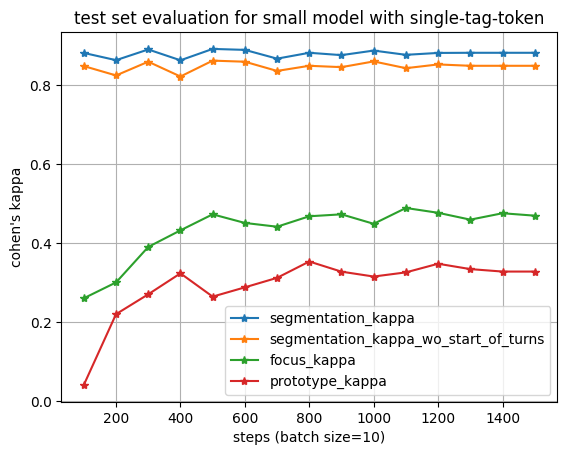

In [54]:
a = pd.read_csv("small_labels_verions_v1_eval_again.csv")
b=a.reset_index()
b=b.assign(steps=b["index"]*100+100)
b=b.set_index("steps")
b[["segmentation_kappa","segmentation_kappa_wo_start_of_turns","focus_kappa","prototype_kappa"]].plot(style="-*")
plt.grid()
plt.xlabel("steps (batch size=10)")
plt.ylabel("cohen's kappa")
plt.title("test set evaluation for small model with single-tag-token")
c1_2 = b[["segmentation_kappa","segmentation_kappa_wo_start_of_turns","focus_kappa","prototype_kappa"]].assign(experiment="v1_again")

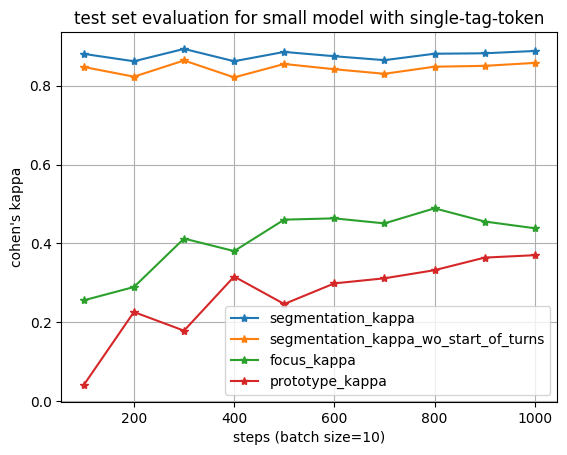

In [55]:
a = pd.read_csv("small_labels_verions_v1_eval.csv")
b=a.reset_index()
b=b.assign(steps=b["index"]*100+100)
b=b.set_index("steps")
b[["segmentation_kappa","segmentation_kappa_wo_start_of_turns","focus_kappa","prototype_kappa"]].plot(style="-*")
plt.grid()
plt.xlabel("steps (batch size=10)")
plt.ylabel("cohen's kappa")
plt.title("test set evaluation for small model with single-tag-token")
c1 = b[["segmentation_kappa","segmentation_kappa_wo_start_of_turns","focus_kappa","prototype_kappa"]].assign(experiment="v1")

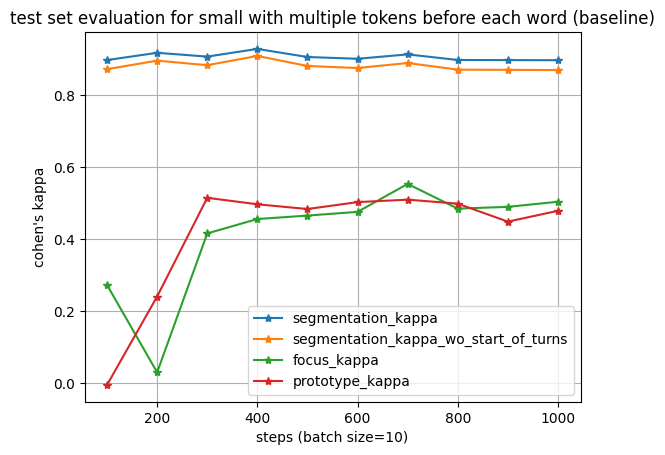

In [56]:
a = pd.read_csv("small_labels_verions_reg_eval.csv")
b=a.reset_index()
b=b.assign(steps=b["index"]*100+100)
b=b.set_index("steps")
b[["segmentation_kappa","segmentation_kappa_wo_start_of_turns","focus_kappa","prototype_kappa"]].plot(style="-*")
plt.grid()
plt.xlabel("steps (batch size=10)")
plt.ylabel("cohen's kappa")
plt.title("test set evaluation for small with multiple tokens before each word (baseline)")
c0 = b[["segmentation_kappa","segmentation_kappa_wo_start_of_turns","focus_kappa","prototype_kappa"]].assign(experiment="baseline")

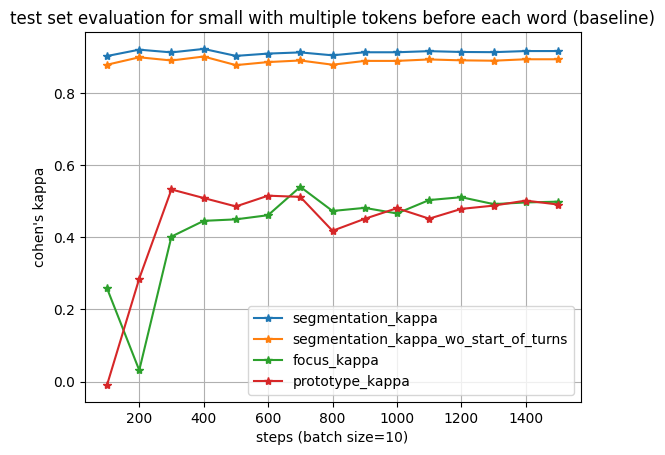

In [57]:
a = pd.read_csv("small_labels_verions_reg_eval_again.csv")
b=a.reset_index()
b=b.assign(steps=b["index"]*100+100)
b=b.set_index("steps")
b[["segmentation_kappa","segmentation_kappa_wo_start_of_turns","focus_kappa","prototype_kappa"]].plot(style="-*")
plt.grid()
plt.xlabel("steps (batch size=10)")
plt.ylabel("cohen's kappa")
plt.title("test set evaluation for small with multiple tokens before each word (baseline)")
c0_2 = b[["segmentation_kappa","segmentation_kappa_wo_start_of_turns","focus_kappa","prototype_kappa"]].assign(experiment="baseline_again")

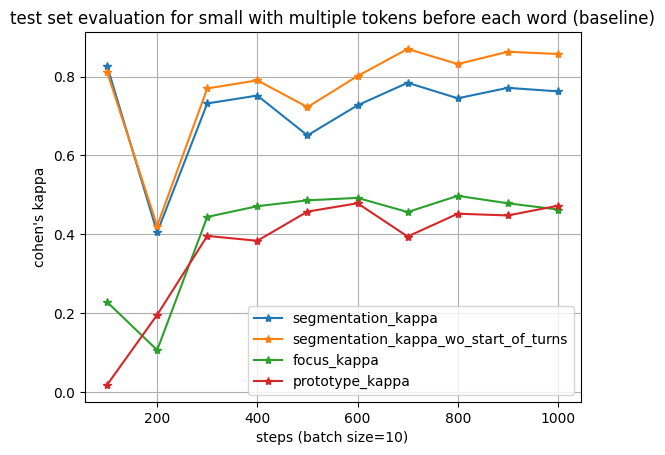

In [58]:
a = pd.read_csv("small_labels_verions_v2_eval.csv")
b=a.reset_index()
b=b.assign(steps=b["index"]*100+100)
b=b.set_index("steps")
b[["segmentation_kappa","segmentation_kappa_wo_start_of_turns","focus_kappa","prototype_kappa"]].plot(style="-*")
plt.grid()
plt.xlabel("steps (batch size=10)")
plt.ylabel("cohen's kappa")
plt.title("test set evaluation for small with multiple tokens before each word (baseline)")
c2 = b[["segmentation_kappa","segmentation_kappa_wo_start_of_turns","focus_kappa","prototype_kappa"]].assign(experiment="v2")

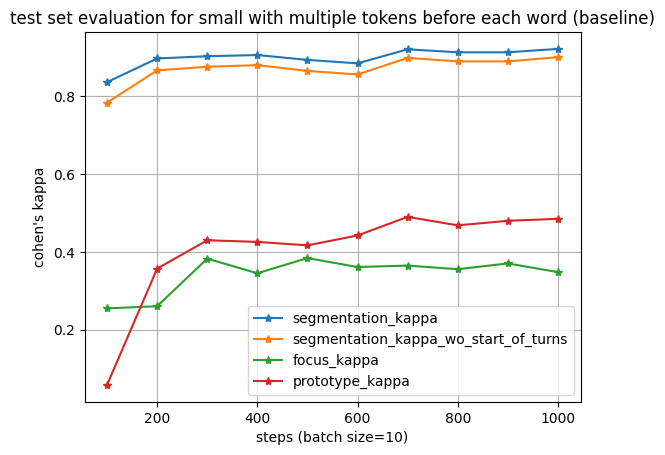

In [59]:
a = pd.read_csv("small_labels_verions_v3_eval.csv")
b=a.reset_index()
b=b.assign(steps=b["index"]*100+100)
b=b.set_index("steps")
b[["segmentation_kappa","segmentation_kappa_wo_start_of_turns","focus_kappa","prototype_kappa"]].plot(style="-*")
plt.grid()
plt.xlabel("steps (batch size=10)")
plt.ylabel("cohen's kappa")
plt.title("test set evaluation for small with multiple tokens before each word (baseline)")
c3 = b[["segmentation_kappa","segmentation_kappa_wo_start_of_turns","focus_kappa","prototype_kappa"]].assign(experiment="v3")

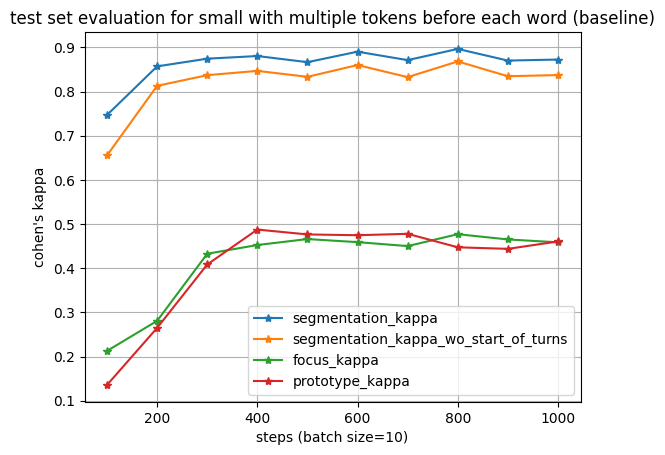

In [60]:
a = pd.read_csv("small_labels_verions_v4_eval.csv")
b=a.reset_index()
b=b.assign(steps=b["index"]*100+100)
b=b.set_index("steps")
b[["segmentation_kappa","segmentation_kappa_wo_start_of_turns","focus_kappa","prototype_kappa"]].plot(style="-*")
plt.grid()
plt.xlabel("steps (batch size=10)")
plt.ylabel("cohen's kappa")
plt.title("test set evaluation for small with multiple tokens before each word (baseline)")
c4 = b[["segmentation_kappa","segmentation_kappa_wo_start_of_turns","focus_kappa","prototype_kappa"]].assign(experiment="v4")

In [68]:
c=pd.concat([
    c0,c0_2,c1,c1_2,c2,c3,c4]).reset_index().set_index(["experiment","steps"])

In [69]:
c

segmentation_kappa  segmentation_kappa_wo_start_of_turns   
experiment steps                                                             
baseline   100              0.897970                              0.872688  \
           200              0.918168                              0.896333   
           300              0.907630                              0.883707   
           400              0.928971                              0.909443   
           500              0.906477                              0.881524   
...                              ...                                   ...   
v4         600              0.890324                              0.860057   
           700              0.871225                              0.832726   
           800              0.896580                              0.868253   
           900              0.870191                              0.834769   
           1000             0.872539                              0.837363   

                  focus_kappa  prototype_kappa  
experiment steps                                
baseline   100       0.272151        -0.005883  
           200       0.029010         0.240123  
           300       0.415671         0.514721  
           400       0.455682         0.496691  
           500       0.465271         0.483499  
...                       ...              ...  
v4         600       0.459137         0.474812  
           700       0.450215         0.477985  
           800       0.477143         0.447469  
           900       0.465255         0.443928  
           1000      0.458711         0.460680  

[80 rows x 4 columns]

In [72]:
cc = c.reset_index(level=0)

cc.experiment.unique()

array(['baseline', 'baseline_again', 'v1', 'v1_again', 'v2', 'v3', 'v4'],
      dtype=object)

Text(0.5, 1.0, 'focus_kappa')

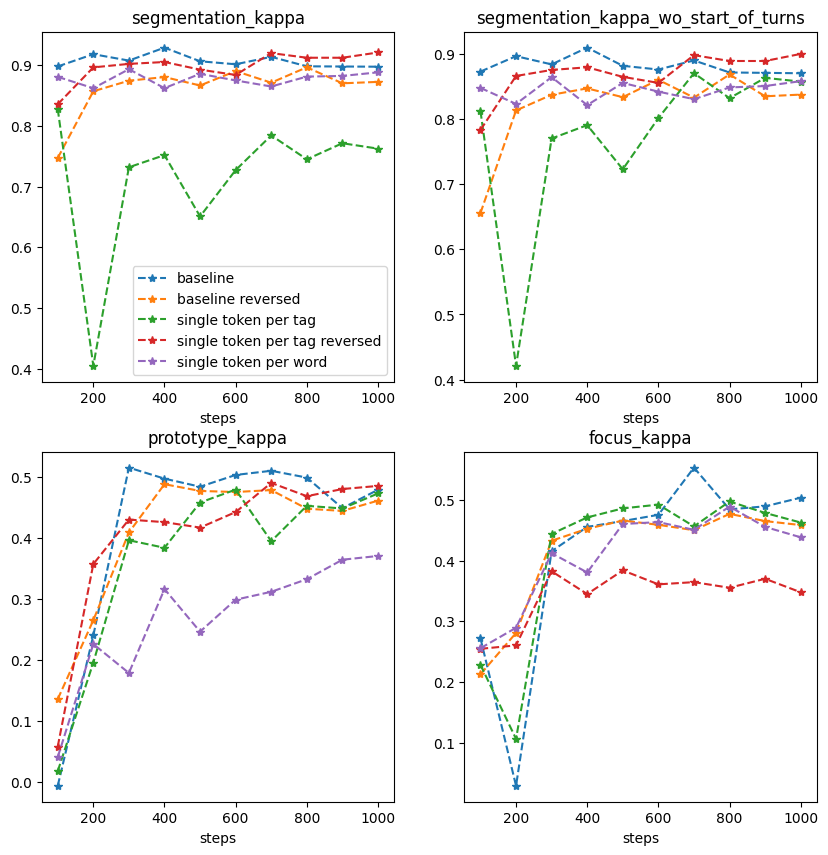

In [63]:
cc = c.reset_index(level=0)
cc.loc[:,"experiment"] = cc["experiment"].map({
    "baseline":"baseline",
    "v1":"single token per word",
    "v2":"single token per tag",
    "v3":"single token per tag reversed",
    "v4":"baseline reversed",
})


fig = plt.figure(figsize=(10,10))
fig.subplots(2,2)
plt.subplot(2,2,1)
cc.groupby("experiment")["segmentation_kappa"].plot(style="--*")
plt.title("segmentation_kappa")
plt.legend()

plt.subplot(2,2,2)
cc.groupby("experiment")["segmentation_kappa_wo_start_of_turns"].plot(style="--*")
plt.title("segmentation_kappa_wo_start_of_turns")

plt.subplot(2,2,3)
cc.groupby("experiment")["prototype_kappa"].plot(style="--*")
plt.title("prototype_kappa")

plt.subplot(2,2,4)
cc.groupby("experiment")["focus_kappa"].plot(style="--*")
plt.title("focus_kappa")


Text(0.5, 1.0, 'focus_kappa')

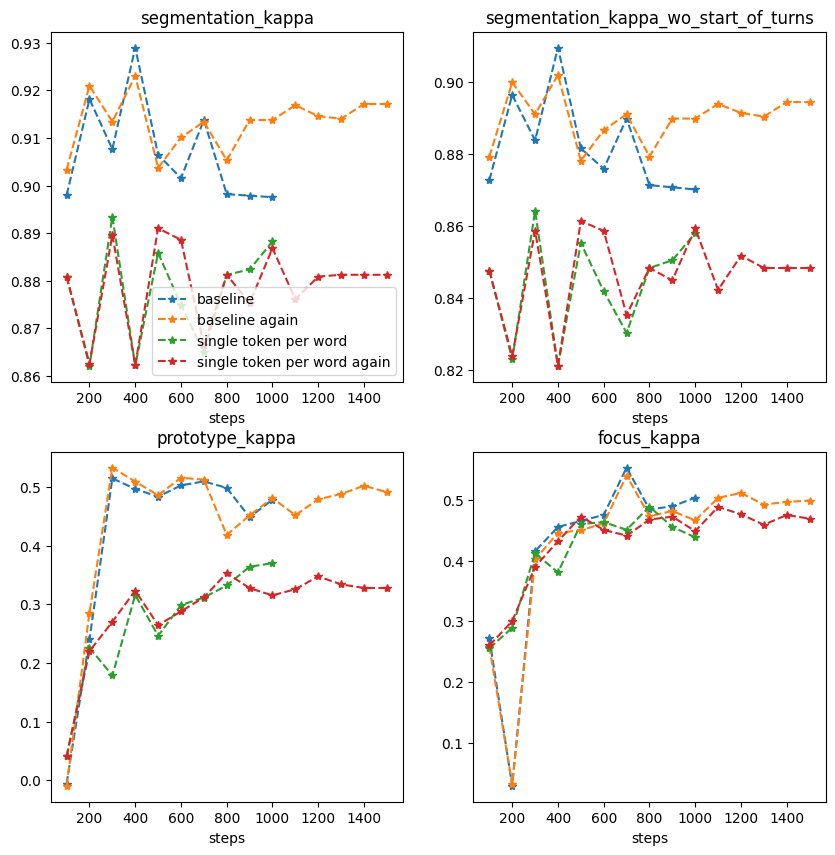

In [79]:
cc = c.reset_index(level=0)
cc.loc[:,"experiment"] = cc["experiment"].map({
    "baseline_again":"baseline again",
    "v1_again":"single token per word again",
    "baseline":"baseline",
    "v1":"single token per word",
    # "v2":"single token per tag",
    # "v3":"single token per tag reversed",
    # "v4":"baseline reversed",
})


fig = plt.figure(figsize=(10,10))
fig.subplots(2,2)
plt.subplot(2,2,1)
cc.groupby("experiment")["segmentation_kappa"].plot(style="--*")
plt.title("segmentation_kappa")
plt.legend()

plt.subplot(2,2,2)
cc.groupby("experiment")["segmentation_kappa_wo_start_of_turns"].plot(style="--*")
plt.title("segmentation_kappa_wo_start_of_turns")

plt.subplot(2,2,3)
cc.groupby("experiment")["prototype_kappa"].plot(style="--*")
plt.title("prototype_kappa")

plt.subplot(2,2,4)
cc.groupby("experiment")["focus_kappa"].plot(style="--*")
plt.title("focus_kappa")


In [47]:
!du -sh /home/yadinb/dharelg/ds_for_yadin_SBC_wo_augmentation

9.4G	/home/yadinb/dharelg/ds_for_yadin_SBC_wo_augmentation/


In [45]:
ds = datasets.Dataset.load_from_disk("/home/yadinb/dharelg/ds_for_yadin_SBC_wo_augmentation/")

In [46]:
ds

Dataset({
    features: ['input_features', 'input_length', 'labels', 'path'],
    num_rows: 2347
})

In [ ]:
ds[0]["input_features"]

In [5]:
common_voice

DatasetDict({
    train: Dataset({
        features: ['input_features', 'input_length', 'audio_path', 'labels'],
        num_rows: 1104
    })
    test: Dataset({
        features: ['input_features', 'input_length', 'audio_path', 'labels'],
        num_rows: 58
    })
})

In [50]:
ds = common_voice["test"]

In [51]:
ds

Dataset({
    features: ['input_features', 'input_length', 'audio_path', 'labels'],
    num_rows: 58
})

In [11]:
common_voice["test"][0]["audio_path"]

'/home/eranbe/dharelg/datasets/whisper_dataset/prototype_dataset/TAL_4prototype_tmpfiles_4creating_dataset/wav/2037.wav'

In [12]:
from IPython.display import Audio
Audio(common_voice["test"][0]["audio_path"],rate=16000)

ValueError: could not convert string to float: '/home/eranbe/dharelg/datasets/whisper_dataset/prototype_dataset/TAL_4prototype_tmpfiles_4creating_dataset/wav/2037.wav'

In [1]:
import datasets

In [2]:
common_voice=datasets.DatasetDict.load_from_disk("/home/moshebr/dharelg/moshe/ds_eran_original")

In [5]:
common_voice["train"][0].keys()

dict_keys(['input_features', 'input_length', 'audio_path', 'labels'])

In [8]:
from IPython.display import Audio
Audio(filename=common_voice["train"][0]["audio_path"])

PermissionError: [Errno 13] Permission denied: '/home/eranbe/dharelg/datasets/whisper_dataset/prototype_dataset/TAL_4prototype_tmpfiles_4creating_dataset/wav/465.wav'

In [150]:
a

DatasetDict({
    train: Dataset({
        features: ['input_features', 'input_length', 'labels'],
        num_rows: 1104
    })
    test: Dataset({
        features: ['input_features', 'input_length', 'labels'],
        num_rows: 58
    })
})